##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2022-12-14 02:23:03.432706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 02:23:03.432824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 02:23:03.432835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 0s

 4202496/68606236 [>.............................] - ETA: 1s

20193280/68606236 [=======>......................] - ETA: 0s

37167104/68606236 [===============>..............] - ETA: 0s

54403072/68606236 [======================>.......] - ETA: 0s

68606236/68606236 [==============================] - 0s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

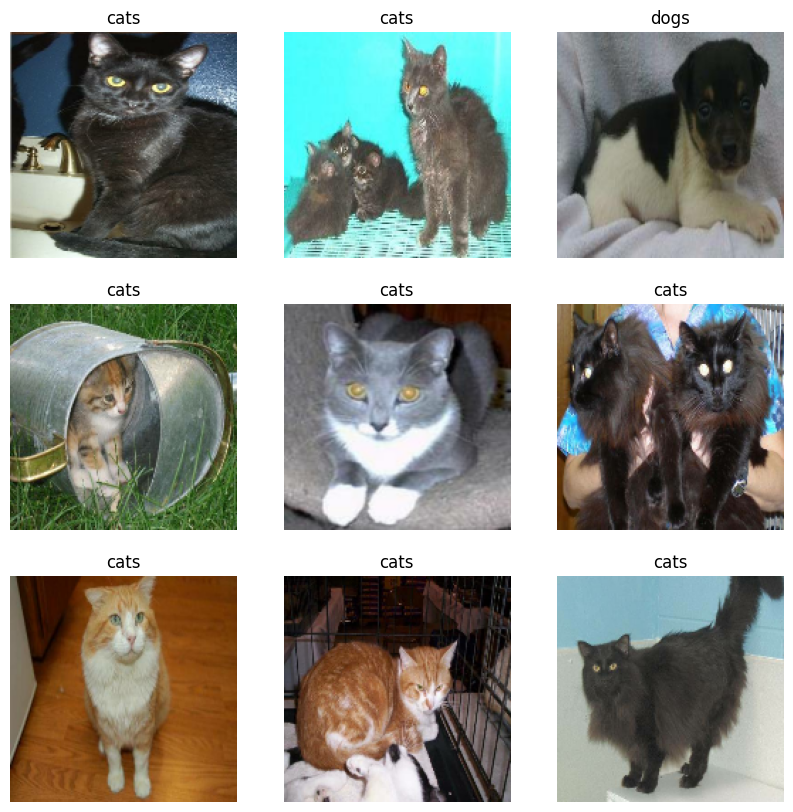

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

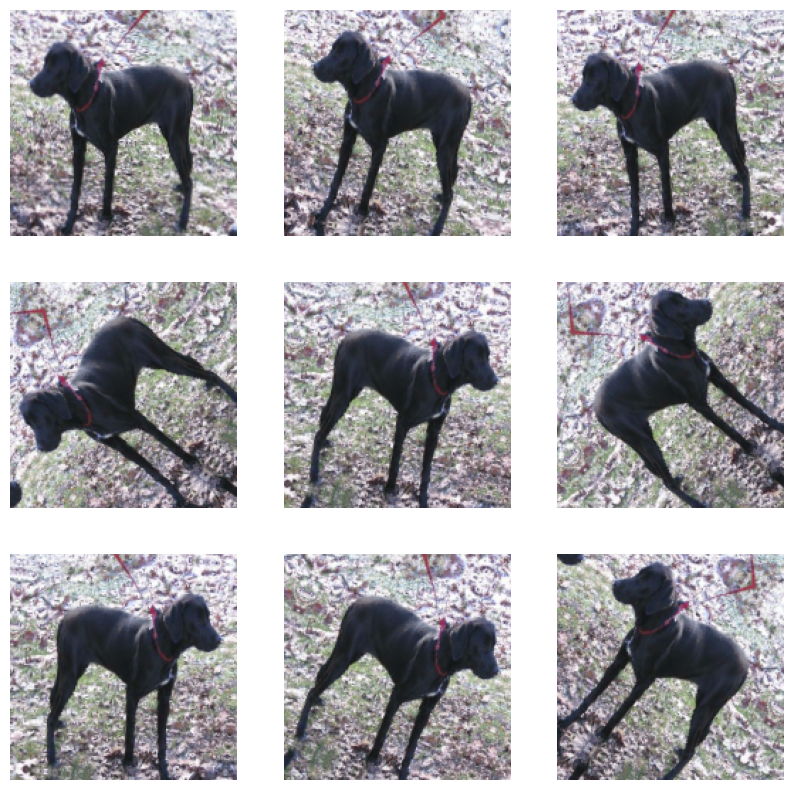

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               


                                )]                                                                


 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                


 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  


 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']               


 expanded_conv_depthwise (Depth  (None, 80, 80, 32)  288         ['Conv1_relu[0][0]']             


 wiseConv2D)                                                                                      


 expanded_conv_depthwise_BN (Ba  (None, 80, 80, 32)  128         ['expanded_conv_depthwise[0][0]']


 tchNormalization)                                                                                


 expanded_conv_depthwise_relu (  (None, 80, 80, 32)  0           ['expanded_conv_depthwise_BN[0][0


 ReLU)                                                           ]']                              


 expanded_conv_project (Conv2D)  (None, 80, 80, 16)  512         ['expanded_conv_depthwise_relu[0]


                                                                 [0]']                            


 expanded_conv_project_BN (Batc  (None, 80, 80, 16)  64          ['expanded_conv_project[0][0]']  


 hNormalization)                                                                                  


 block_1_expand (Conv2D)        (None, 80, 80, 96)   1536        ['expanded_conv_project_BN[0][0]'


                                                                 ]                                


 block_1_expand_BN (BatchNormal  (None, 80, 80, 96)  384         ['block_1_expand[0][0]']         


 ization)                                                                                         


 block_1_expand_relu (ReLU)     (None, 80, 80, 96)   0           ['block_1_expand_BN[0][0]']      


 block_1_pad (ZeroPadding2D)    (None, 81, 81, 96)   0           ['block_1_expand_relu[0][0]']    


 block_1_depthwise (DepthwiseCo  (None, 40, 40, 96)  864         ['block_1_pad[0][0]']            


 nv2D)                                                                                            


 block_1_depthwise_BN (BatchNor  (None, 40, 40, 96)  384         ['block_1_depthwise[0][0]']      


 malization)                                                                                      


 block_1_depthwise_relu (ReLU)  (None, 40, 40, 96)   0           ['block_1_depthwise_BN[0][0]']   


 block_1_project (Conv2D)       (None, 40, 40, 24)   2304        ['block_1_depthwise_relu[0][0]'] 


 block_1_project_BN (BatchNorma  (None, 40, 40, 24)  96          ['block_1_project[0][0]']        


 lization)                                                                                        


 block_2_expand (Conv2D)        (None, 40, 40, 144)  3456        ['block_1_project_BN[0][0]']     


 block_2_expand_BN (BatchNormal  (None, 40, 40, 144)  576        ['block_2_expand[0][0]']         


 ization)                                                                                         


 block_2_expand_relu (ReLU)     (None, 40, 40, 144)  0           ['block_2_expand_BN[0][0]']      


 block_2_depthwise (DepthwiseCo  (None, 40, 40, 144)  1296       ['block_2_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_2_depthwise_BN (BatchNor  (None, 40, 40, 144)  576        ['block_2_depthwise[0][0]']      


 malization)                                                                                      


 block_2_depthwise_relu (ReLU)  (None, 40, 40, 144)  0           ['block_2_depthwise_BN[0][0]']   


 block_2_project (Conv2D)       (None, 40, 40, 24)   3456        ['block_2_depthwise_relu[0][0]'] 


 block_2_project_BN (BatchNorma  (None, 40, 40, 24)  96          ['block_2_project[0][0]']        


 lization)                                                                                        


 block_2_add (Add)              (None, 40, 40, 24)   0           ['block_1_project_BN[0][0]',     


                                                                  'block_2_project_BN[0][0]']     


 block_3_expand (Conv2D)        (None, 40, 40, 144)  3456        ['block_2_add[0][0]']            


 block_3_expand_BN (BatchNormal  (None, 40, 40, 144)  576        ['block_3_expand[0][0]']         


 ization)                                                                                         


 block_3_expand_relu (ReLU)     (None, 40, 40, 144)  0           ['block_3_expand_BN[0][0]']      


 block_3_pad (ZeroPadding2D)    (None, 41, 41, 144)  0           ['block_3_expand_relu[0][0]']    


 block_3_depthwise (DepthwiseCo  (None, 20, 20, 144)  1296       ['block_3_pad[0][0]']            


 nv2D)                                                                                            


 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      


 malization)                                                                                      


 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   


 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 


 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        


 lization)                                                                                        


 block_4_expand (Conv2D)        (None, 20, 20, 192)  6144        ['block_3_project_BN[0][0]']     


 block_4_expand_BN (BatchNormal  (None, 20, 20, 192)  768        ['block_4_expand[0][0]']         


 ization)                                                                                         


 block_4_expand_relu (ReLU)     (None, 20, 20, 192)  0           ['block_4_expand_BN[0][0]']      


 block_4_depthwise (DepthwiseCo  (None, 20, 20, 192)  1728       ['block_4_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_4_depthwise_BN (BatchNor  (None, 20, 20, 192)  768        ['block_4_depthwise[0][0]']      


 malization)                                                                                      


 block_4_depthwise_relu (ReLU)  (None, 20, 20, 192)  0           ['block_4_depthwise_BN[0][0]']   


 block_4_project (Conv2D)       (None, 20, 20, 32)   6144        ['block_4_depthwise_relu[0][0]'] 


 block_4_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_4_project[0][0]']        


 lization)                                                                                        


 block_4_add (Add)              (None, 20, 20, 32)   0           ['block_3_project_BN[0][0]',     


                                                                  'block_4_project_BN[0][0]']     


 block_5_expand (Conv2D)        (None, 20, 20, 192)  6144        ['block_4_add[0][0]']            


 block_5_expand_BN (BatchNormal  (None, 20, 20, 192)  768        ['block_5_expand[0][0]']         


 ization)                                                                                         


 block_5_expand_relu (ReLU)     (None, 20, 20, 192)  0           ['block_5_expand_BN[0][0]']      


 block_5_depthwise (DepthwiseCo  (None, 20, 20, 192)  1728       ['block_5_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_5_depthwise_BN (BatchNor  (None, 20, 20, 192)  768        ['block_5_depthwise[0][0]']      


 malization)                                                                                      


 block_5_depthwise_relu (ReLU)  (None, 20, 20, 192)  0           ['block_5_depthwise_BN[0][0]']   


 block_5_project (Conv2D)       (None, 20, 20, 32)   6144        ['block_5_depthwise_relu[0][0]'] 


 block_5_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_5_project[0][0]']        


 lization)                                                                                        


 block_5_add (Add)              (None, 20, 20, 32)   0           ['block_4_add[0][0]',            


                                                                  'block_5_project_BN[0][0]']     


 block_6_expand (Conv2D)        (None, 20, 20, 192)  6144        ['block_5_add[0][0]']            


 block_6_expand_BN (BatchNormal  (None, 20, 20, 192)  768        ['block_6_expand[0][0]']         


 ization)                                                                                         


 block_6_expand_relu (ReLU)     (None, 20, 20, 192)  0           ['block_6_expand_BN[0][0]']      


 block_6_pad (ZeroPadding2D)    (None, 21, 21, 192)  0           ['block_6_expand_relu[0][0]']    


 block_6_depthwise (DepthwiseCo  (None, 10, 10, 192)  1728       ['block_6_pad[0][0]']            


 nv2D)                                                                                            


 block_6_depthwise_BN (BatchNor  (None, 10, 10, 192)  768        ['block_6_depthwise[0][0]']      


 malization)                                                                                      


 block_6_depthwise_relu (ReLU)  (None, 10, 10, 192)  0           ['block_6_depthwise_BN[0][0]']   


 block_6_project (Conv2D)       (None, 10, 10, 64)   12288       ['block_6_depthwise_relu[0][0]'] 


 block_6_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_6_project[0][0]']        


 lization)                                                                                        


 block_7_expand (Conv2D)        (None, 10, 10, 384)  24576       ['block_6_project_BN[0][0]']     


 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         


 ization)                                                                                         


 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      


 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      


 malization)                                                                                      


 block_7_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_7_depthwise_BN[0][0]']   


 block_7_project (Conv2D)       (None, 10, 10, 64)   24576       ['block_7_depthwise_relu[0][0]'] 


 block_7_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_7_project[0][0]']        


 lization)                                                                                        


 block_7_add (Add)              (None, 10, 10, 64)   0           ['block_6_project_BN[0][0]',     


                                                                  'block_7_project_BN[0][0]']     


 block_8_expand (Conv2D)        (None, 10, 10, 384)  24576       ['block_7_add[0][0]']            


 block_8_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_8_expand[0][0]']         


 ization)                                                                                         


 block_8_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_8_expand_BN[0][0]']      


 block_8_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_8_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_8_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_8_depthwise[0][0]']      


 malization)                                                                                      


 block_8_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_8_depthwise_BN[0][0]']   


 block_8_project (Conv2D)       (None, 10, 10, 64)   24576       ['block_8_depthwise_relu[0][0]'] 


 block_8_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_8_project[0][0]']        


 lization)                                                                                        


 block_8_add (Add)              (None, 10, 10, 64)   0           ['block_7_add[0][0]',            


                                                                  'block_8_project_BN[0][0]']     


 block_9_expand (Conv2D)        (None, 10, 10, 384)  24576       ['block_8_add[0][0]']            


 block_9_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_9_expand[0][0]']         


 ization)                                                                                         


 block_9_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_9_expand_BN[0][0]']      


 block_9_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_9_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_9_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_9_depthwise[0][0]']      


 malization)                                                                                      


 block_9_depthwise_relu (ReLU)  (None, 10, 10, 384)  0           ['block_9_depthwise_BN[0][0]']   


 block_9_project (Conv2D)       (None, 10, 10, 64)   24576       ['block_9_depthwise_relu[0][0]'] 


 block_9_project_BN (BatchNorma  (None, 10, 10, 64)  256         ['block_9_project[0][0]']        


 lization)                                                                                        


 block_9_add (Add)              (None, 10, 10, 64)   0           ['block_8_add[0][0]',            


                                                                  'block_9_project_BN[0][0]']     


 block_10_expand (Conv2D)       (None, 10, 10, 384)  24576       ['block_9_add[0][0]']            


 block_10_expand_BN (BatchNorma  (None, 10, 10, 384)  1536       ['block_10_expand[0][0]']        


 lization)                                                                                        


 block_10_expand_relu (ReLU)    (None, 10, 10, 384)  0           ['block_10_expand_BN[0][0]']     


 block_10_depthwise (DepthwiseC  (None, 10, 10, 384)  3456       ['block_10_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_10_depthwise_BN (BatchNo  (None, 10, 10, 384)  1536       ['block_10_depthwise[0][0]']     


 rmalization)                                                                                     


 block_10_depthwise_relu (ReLU)  (None, 10, 10, 384)  0          ['block_10_depthwise_BN[0][0]']  


 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']


 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       


 alization)                                                                                       


 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    


 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        


 lization)                                                                                        


 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     


 block_11_depthwise (DepthwiseC  (None, 10, 10, 576)  5184       ['block_11_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_11_depthwise_BN (BatchNo  (None, 10, 10, 576)  2304       ['block_11_depthwise[0][0]']     


 rmalization)                                                                                     


 block_11_depthwise_relu (ReLU)  (None, 10, 10, 576)  0          ['block_11_depthwise_BN[0][0]']  


 block_11_project (Conv2D)      (None, 10, 10, 96)   55296       ['block_11_depthwise_relu[0][0]']


 block_11_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_11_project[0][0]']       


 alization)                                                                                       


 block_11_add (Add)             (None, 10, 10, 96)   0           ['block_10_project_BN[0][0]',    


                                                                  'block_11_project_BN[0][0]']    


 block_12_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_11_add[0][0]']           


 block_12_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_12_expand[0][0]']        


 lization)                                                                                        


 block_12_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_12_expand_BN[0][0]']     


 block_12_depthwise (DepthwiseC  (None, 10, 10, 576)  5184       ['block_12_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_12_depthwise_BN (BatchNo  (None, 10, 10, 576)  2304       ['block_12_depthwise[0][0]']     


 rmalization)                                                                                     


 block_12_depthwise_relu (ReLU)  (None, 10, 10, 576)  0          ['block_12_depthwise_BN[0][0]']  


 block_12_project (Conv2D)      (None, 10, 10, 96)   55296       ['block_12_depthwise_relu[0][0]']


 block_12_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_12_project[0][0]']       


 alization)                                                                                       


 block_12_add (Add)             (None, 10, 10, 96)   0           ['block_11_add[0][0]',           


                                                                  'block_12_project_BN[0][0]']    


 block_13_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_12_add[0][0]']           


 block_13_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_13_expand[0][0]']        


 lization)                                                                                        


 block_13_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_13_expand_BN[0][0]']     


 block_13_pad (ZeroPadding2D)   (None, 11, 11, 576)  0           ['block_13_expand_relu[0][0]']   


 block_13_depthwise (DepthwiseC  (None, 5, 5, 576)   5184        ['block_13_pad[0][0]']           


 onv2D)                                                                                           


 block_13_depthwise_BN (BatchNo  (None, 5, 5, 576)   2304        ['block_13_depthwise[0][0]']     


 rmalization)                                                                                     


 block_13_depthwise_relu (ReLU)  (None, 5, 5, 576)   0           ['block_13_depthwise_BN[0][0]']  


 block_13_project (Conv2D)      (None, 5, 5, 160)    92160       ['block_13_depthwise_relu[0][0]']


 block_13_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_13_project[0][0]']       


 alization)                                                                                       


 block_14_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_13_project_BN[0][0]']    


 block_14_expand_BN (BatchNorma  (None, 5, 5, 960)   3840        ['block_14_expand[0][0]']        


 lization)                                                                                        


 block_14_expand_relu (ReLU)    (None, 5, 5, 960)    0           ['block_14_expand_BN[0][0]']     


 block_14_depthwise (DepthwiseC  (None, 5, 5, 960)   8640        ['block_14_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     


 rmalization)                                                                                     


 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  


 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']


 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       


 alization)                                                                                       


 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    


                                                                  'block_14_project_BN[0][0]']    


 block_15_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_14_add[0][0]']           


 block_15_expand_BN (BatchNorma  (None, 5, 5, 960)   3840        ['block_15_expand[0][0]']        


 lization)                                                                                        


 block_15_expand_relu (ReLU)    (None, 5, 5, 960)    0           ['block_15_expand_BN[0][0]']     


 block_15_depthwise (DepthwiseC  (None, 5, 5, 960)   8640        ['block_15_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_15_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_15_depthwise[0][0]']     


 rmalization)                                                                                     


 block_15_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_15_depthwise_BN[0][0]']  


 block_15_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_15_depthwise_relu[0][0]']


 block_15_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_15_project[0][0]']       


 alization)                                                                                       


 block_15_add (Add)             (None, 5, 5, 160)    0           ['block_14_add[0][0]',           


                                                                  'block_15_project_BN[0][0]']    


 block_16_expand (Conv2D)       (None, 5, 5, 960)    153600      ['block_15_add[0][0]']           


 block_16_expand_BN (BatchNorma  (None, 5, 5, 960)   3840        ['block_16_expand[0][0]']        


 lization)                                                                                        


 block_16_expand_relu (ReLU)    (None, 5, 5, 960)    0           ['block_16_expand_BN[0][0]']     


 block_16_depthwise (DepthwiseC  (None, 5, 5, 960)   8640        ['block_16_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_16_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_16_depthwise[0][0]']     


 rmalization)                                                                                     


 block_16_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_16_depthwise_BN[0][0]']  


 block_16_project (Conv2D)      (None, 5, 5, 320)    307200      ['block_16_depthwise_relu[0][0]']


 block_16_project_BN (BatchNorm  (None, 5, 5, 320)   1280        ['block_16_project[0][0]']       


 alization)                                                                                       


 Conv_1 (Conv2D)                (None, 5, 5, 1280)   409600      ['block_16_project_BN[0][0]']    


 Conv_1_bn (BatchNormalization)  (None, 5, 5, 1280)  5120        ['Conv_1[0][0]']                 


 out_relu (ReLU)                (None, 5, 5, 1280)   0           ['Conv_1_bn[0][0]']              


Total params: 2,257,984


Trainable params: 0


Non-trainable params: 2,257,984


__________________________________________________________________________________________________


### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,281


Non-trainable params: 2,257,984


_________________________________________________________________


The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 35s - loss: 0.8554 - accuracy: 0.3438

 4/26 [===>..........................] - ETA: 0s - loss: 0.8569 - accuracy: 0.3984 

 7/26 [=======>......................] - ETA: 0s - loss: 0.8305 - accuracy: 0.4062

10/26 [==========>...................] - ETA: 0s - loss: 0.8392 - accuracy: 0.3969

13/26 [==============>...............] - ETA: 0s - loss: 0.8560 - accuracy: 0.3870

16/26 [=================>............] - ETA: 0s - loss: 0.8588 - accuracy: 0.4023

19/26 [====================>.........] - ETA: 0s - loss: 0.8601 - accuracy: 0.4062

22/26 [========================>.....] - ETA: 0s - loss: 0.8623 - accuracy: 0.4119

25/26 [===========================>..] - ETA: 0s - loss: 0.8711 - accuracy: 0.4125

26/26 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.4134

26/26 [==============================] - 2s 21ms/step - loss: 0.8703 - accuracy: 0.4134


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.41


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 4:16 - loss: 0.8905 - accuracy: 0.5000

 2/63 [..............................] - ETA: 3s - loss: 0.9054 - accuracy: 0.4531  

 3/63 [>.............................] - ETA: 3s - loss: 0.9805 - accuracy: 0.3958

 4/63 [>.............................] - ETA: 3s - loss: 0.9622 - accuracy: 0.3750

 5/63 [=>............................] - ETA: 3s - loss: 0.9444 - accuracy: 0.3688

 6/63 [=>............................] - ETA: 3s - loss: 0.9378 - accuracy: 0.3750

 7/63 [==>...........................] - ETA: 3s - loss: 0.9203 - accuracy: 0.3973

 8/63 [==>...........................] - ETA: 3s - loss: 0.8943 - accuracy: 0.4219

 9/63 [===>..........................] - ETA: 3s - loss: 0.9031 - accuracy: 0.4271

10/63 [===>..........................] - ETA: 3s - loss: 0.9029 - accuracy: 0.4313

11/63 [====>.........................] - ETA: 3s - loss: 0.8967 - accuracy: 0.4347

12/63 [====>.........................] - ETA: 2s - loss: 0.8890 - accuracy: 0.4453

13/63 [=====>........................] - ETA: 2s - loss: 0.8924 - accuracy: 0.4447

14/63 [=====>........................] - ETA: 2s - loss: 0.8957 - accuracy: 0.4442

15/63 [======>.......................] - ETA: 2s - loss: 0.9001 - accuracy: 0.4396

16/63 [======>.......................] - ETA: 2s - loss: 0.8928 - accuracy: 0.4355

17/63 [=======>......................] - ETA: 2s - loss: 0.8884 - accuracy: 0.4357

18/63 [=======>......................] - ETA: 2s - loss: 0.8976 - accuracy: 0.4288

19/63 [========>.....................] - ETA: 2s - loss: 0.9092 - accuracy: 0.4293

20/63 [========>.....................] - ETA: 2s - loss: 0.9127 - accuracy: 0.4297

21/63 [=========>....................] - ETA: 2s - loss: 0.9070 - accuracy: 0.4330

22/63 [=========>....................] - ETA: 2s - loss: 0.9011 - accuracy: 0.4389

23/63 [=========>....................] - ETA: 2s - loss: 0.8882 - accuracy: 0.4511

24/63 [==========>...................] - ETA: 2s - loss: 0.8838 - accuracy: 0.4505

25/63 [==========>...................] - ETA: 2s - loss: 0.8817 - accuracy: 0.4512

26/63 [===========>..................] - ETA: 2s - loss: 0.8826 - accuracy: 0.4471

27/63 [===========>..................] - ETA: 2s - loss: 0.8773 - accuracy: 0.4525

28/63 [============>.................] - ETA: 2s - loss: 0.8766 - accuracy: 0.4498

29/63 [============>.................] - ETA: 2s - loss: 0.8712 - accuracy: 0.4515

30/63 [=============>................] - ETA: 1s - loss: 0.8732 - accuracy: 0.4490

31/63 [=============>................] - ETA: 1s - loss: 0.8677 - accuracy: 0.4526

32/63 [==============>...............] - ETA: 1s - loss: 0.8611 - accuracy: 0.4590

33/63 [==============>...............] - ETA: 1s - loss: 0.8561 - accuracy: 0.4621

34/63 [===============>..............] - ETA: 1s - loss: 0.8548 - accuracy: 0.4623

35/63 [===============>..............] - ETA: 1s - loss: 0.8498 - accuracy: 0.4661

36/63 [================>.............] - ETA: 1s - loss: 0.8451 - accuracy: 0.4696

37/63 [================>.............] - ETA: 1s - loss: 0.8463 - accuracy: 0.4696

38/63 [=================>............] - ETA: 1s - loss: 0.8445 - accuracy: 0.4704

39/63 [=================>............] - ETA: 1s - loss: 0.8412 - accuracy: 0.4728

40/63 [==================>...........] - ETA: 1s - loss: 0.8424 - accuracy: 0.4742

41/63 [==================>...........] - ETA: 1s - loss: 0.8418 - accuracy: 0.4764

42/63 [===================>..........] - ETA: 1s - loss: 0.8438 - accuracy: 0.4747

43/63 [===================>..........] - ETA: 1s - loss: 0.8410 - accuracy: 0.4753

44/63 [===================>..........] - ETA: 1s - loss: 0.8356 - accuracy: 0.4759

45/63 [====================>.........] - ETA: 1s - loss: 0.8337 - accuracy: 0.4771

46/63 [====================>.........] - ETA: 0s - loss: 0.8329 - accuracy: 0.4783

47/63 [=====================>........] - ETA: 0s - loss: 0.8295 - accuracy: 0.4787

48/63 [=====================>........] - ETA: 0s - loss: 0.8236 - accuracy: 0.4824

49/63 [======================>.......] - ETA: 0s - loss: 0.8211 - accuracy: 0.4828

50/63 [======================>.......] - ETA: 0s - loss: 0.8177 - accuracy: 0.4863

51/63 [=======================>......] - ETA: 0s - loss: 0.8153 - accuracy: 0.4896

52/63 [=======================>......] - ETA: 0s - loss: 0.8171 - accuracy: 0.4904

53/63 [========================>.....] - ETA: 0s - loss: 0.8120 - accuracy: 0.4935

54/63 [========================>.....] - ETA: 0s - loss: 0.8103 - accuracy: 0.4936

55/63 [=========================>....] - ETA: 0s - loss: 0.8103 - accuracy: 0.4949

56/63 [=========================>....] - ETA: 0s - loss: 0.8133 - accuracy: 0.4933

57/63 [==========================>...] - ETA: 0s - loss: 0.8090 - accuracy: 0.4984

58/63 [==========================>...] - ETA: 0s - loss: 0.8088 - accuracy: 0.4978

59/63 [===========================>..] - ETA: 0s - loss: 0.8066 - accuracy: 0.4979

60/63 [===========================>..] - ETA: 0s - loss: 0.8029 - accuracy: 0.5005

61/63 [============================>.] - ETA: 0s - loss: 0.8008 - accuracy: 0.5026

62/63 [============================>.] - ETA: 0s - loss: 0.7970 - accuracy: 0.5040

63/63 [==============================] - ETA: 0s - loss: 0.7968 - accuracy: 0.5040

63/63 [==============================] - 8s 67ms/step - loss: 0.7968 - accuracy: 0.5040 - val_loss: 0.6079 - val_accuracy: 0.5903


Epoch 2/10


 1/63 [..............................] - ETA: 5s - loss: 0.7477 - accuracy: 0.6562

 2/63 [..............................] - ETA: 3s - loss: 0.6645 - accuracy: 0.5781

 3/63 [>.............................] - ETA: 3s - loss: 0.6270 - accuracy: 0.6146

 4/63 [>.............................] - ETA: 3s - loss: 0.6283 - accuracy: 0.6094

 5/63 [=>............................] - ETA: 3s - loss: 0.6163 - accuracy: 0.6062

 6/63 [=>............................] - ETA: 3s - loss: 0.6437 - accuracy: 0.6042

 7/63 [==>...........................] - ETA: 3s - loss: 0.6335 - accuracy: 0.5982

 8/63 [==>...........................] - ETA: 3s - loss: 0.6311 - accuracy: 0.6133

 9/63 [===>..........................] - ETA: 3s - loss: 0.6475 - accuracy: 0.6111

10/63 [===>..........................] - ETA: 3s - loss: 0.6521 - accuracy: 0.6094

11/63 [====>.........................] - ETA: 3s - loss: 0.6421 - accuracy: 0.6250

12/63 [====>.........................] - ETA: 2s - loss: 0.6353 - accuracy: 0.6276

13/63 [=====>........................] - ETA: 2s - loss: 0.6403 - accuracy: 0.6250

14/63 [=====>........................] - ETA: 2s - loss: 0.6460 - accuracy: 0.6183

15/63 [======>.......................] - ETA: 2s - loss: 0.6400 - accuracy: 0.6167

16/63 [======>.......................] - ETA: 2s - loss: 0.6438 - accuracy: 0.6152

17/63 [=======>......................] - ETA: 2s - loss: 0.6434 - accuracy: 0.6158

18/63 [=======>......................] - ETA: 2s - loss: 0.6388 - accuracy: 0.6163

19/63 [========>.....................] - ETA: 2s - loss: 0.6404 - accuracy: 0.6102

20/63 [========>.....................] - ETA: 2s - loss: 0.6406 - accuracy: 0.6047

21/63 [=========>....................] - ETA: 2s - loss: 0.6472 - accuracy: 0.6042

22/63 [=========>....................] - ETA: 2s - loss: 0.6475 - accuracy: 0.5994

23/63 [=========>....................] - ETA: 2s - loss: 0.6457 - accuracy: 0.6019

24/63 [==========>...................] - ETA: 2s - loss: 0.6475 - accuracy: 0.6003

25/63 [==========>...................] - ETA: 2s - loss: 0.6415 - accuracy: 0.6062

26/63 [===========>..................] - ETA: 2s - loss: 0.6416 - accuracy: 0.6046

27/63 [===========>..................] - ETA: 2s - loss: 0.6438 - accuracy: 0.6053

28/63 [============>.................] - ETA: 2s - loss: 0.6385 - accuracy: 0.6116

29/63 [============>.................] - ETA: 1s - loss: 0.6380 - accuracy: 0.6142

30/63 [=============>................] - ETA: 1s - loss: 0.6364 - accuracy: 0.6167

31/63 [=============>................] - ETA: 1s - loss: 0.6336 - accuracy: 0.6179

32/63 [==============>...............] - ETA: 1s - loss: 0.6334 - accuracy: 0.6201

33/63 [==============>...............] - ETA: 1s - loss: 0.6312 - accuracy: 0.6231

34/63 [===============>..............] - ETA: 1s - loss: 0.6286 - accuracy: 0.6232

35/63 [===============>..............] - ETA: 1s - loss: 0.6276 - accuracy: 0.6250

36/63 [================>.............] - ETA: 1s - loss: 0.6288 - accuracy: 0.6250

37/63 [================>.............] - ETA: 1s - loss: 0.6273 - accuracy: 0.6242

38/63 [=================>............] - ETA: 1s - loss: 0.6235 - accuracy: 0.6275

39/63 [=================>............] - ETA: 1s - loss: 0.6231 - accuracy: 0.6266

40/63 [==================>...........] - ETA: 1s - loss: 0.6197 - accuracy: 0.6266

41/63 [==================>...........] - ETA: 1s - loss: 0.6162 - accuracy: 0.6303

42/63 [===================>..........] - ETA: 1s - loss: 0.6162 - accuracy: 0.6332

43/63 [===================>..........] - ETA: 1s - loss: 0.6141 - accuracy: 0.6344

44/63 [===================>..........] - ETA: 1s - loss: 0.6135 - accuracy: 0.6328

45/63 [====================>.........] - ETA: 1s - loss: 0.6141 - accuracy: 0.6319

46/63 [====================>.........] - ETA: 0s - loss: 0.6121 - accuracy: 0.6338

47/63 [=====================>........] - ETA: 0s - loss: 0.6122 - accuracy: 0.6323

48/63 [=====================>........] - ETA: 0s - loss: 0.6079 - accuracy: 0.6335

49/63 [======================>.......] - ETA: 0s - loss: 0.6073 - accuracy: 0.6346

50/63 [======================>.......] - ETA: 0s - loss: 0.6064 - accuracy: 0.6363

51/63 [=======================>......] - ETA: 0s - loss: 0.6047 - accuracy: 0.6391

52/63 [=======================>......] - ETA: 0s - loss: 0.6025 - accuracy: 0.6412

53/63 [========================>.....] - ETA: 0s - loss: 0.6032 - accuracy: 0.6409

54/63 [========================>.....] - ETA: 0s - loss: 0.6005 - accuracy: 0.6418

55/63 [=========================>....] - ETA: 0s - loss: 0.6010 - accuracy: 0.6420

56/63 [=========================>....] - ETA: 0s - loss: 0.5992 - accuracy: 0.6440

57/63 [==========================>...] - ETA: 0s - loss: 0.5994 - accuracy: 0.6442

58/63 [==========================>...] - ETA: 0s - loss: 0.5957 - accuracy: 0.6471

59/63 [===========================>..] - ETA: 0s - loss: 0.5947 - accuracy: 0.6472

60/63 [===========================>..] - ETA: 0s - loss: 0.5941 - accuracy: 0.6490

61/63 [============================>.] - ETA: 0s - loss: 0.5915 - accuracy: 0.6516

62/63 [============================>.] - ETA: 0s - loss: 0.5895 - accuracy: 0.6537

63/63 [==============================] - 4s 66ms/step - loss: 0.5879 - accuracy: 0.6555 - val_loss: 0.4375 - val_accuracy: 0.7302


Epoch 3/10


 1/63 [..............................] - ETA: 5s - loss: 0.5516 - accuracy: 0.7188

 2/63 [..............................] - ETA: 3s - loss: 0.5315 - accuracy: 0.7344

 3/63 [>.............................] - ETA: 3s - loss: 0.4881 - accuracy: 0.7500

 4/63 [>.............................] - ETA: 3s - loss: 0.5110 - accuracy: 0.7422

 5/63 [=>............................] - ETA: 3s - loss: 0.4898 - accuracy: 0.7625

 6/63 [=>............................] - ETA: 3s - loss: 0.5033 - accuracy: 0.7552

 7/63 [==>...........................] - ETA: 3s - loss: 0.4967 - accuracy: 0.7634

 8/63 [==>...........................] - ETA: 3s - loss: 0.5071 - accuracy: 0.7500

 9/63 [===>..........................] - ETA: 3s - loss: 0.5065 - accuracy: 0.7500

10/63 [===>..........................] - ETA: 3s - loss: 0.5191 - accuracy: 0.7531

11/63 [====>.........................] - ETA: 3s - loss: 0.5250 - accuracy: 0.7415

12/63 [====>.........................] - ETA: 2s - loss: 0.5190 - accuracy: 0.7318

13/63 [=====>........................] - ETA: 2s - loss: 0.5223 - accuracy: 0.7188

14/63 [=====>........................] - ETA: 2s - loss: 0.5131 - accuracy: 0.7277

15/63 [======>.......................] - ETA: 2s - loss: 0.5097 - accuracy: 0.7271

16/63 [======>.......................] - ETA: 2s - loss: 0.5069 - accuracy: 0.7285

17/63 [=======>......................] - ETA: 2s - loss: 0.5110 - accuracy: 0.7243

18/63 [=======>......................] - ETA: 2s - loss: 0.5001 - accuracy: 0.7292

19/63 [========>.....................] - ETA: 2s - loss: 0.4989 - accuracy: 0.7319

20/63 [========>.....................] - ETA: 2s - loss: 0.4983 - accuracy: 0.7344

21/63 [=========>....................] - ETA: 2s - loss: 0.4961 - accuracy: 0.7411

22/63 [=========>....................] - ETA: 2s - loss: 0.4891 - accuracy: 0.7472

23/63 [=========>....................] - ETA: 2s - loss: 0.4922 - accuracy: 0.7446

24/63 [==========>...................] - ETA: 2s - loss: 0.4951 - accuracy: 0.7370

25/63 [==========>...................] - ETA: 2s - loss: 0.4940 - accuracy: 0.7387

26/63 [===========>..................] - ETA: 2s - loss: 0.4909 - accuracy: 0.7392

27/63 [===========>..................] - ETA: 2s - loss: 0.4909 - accuracy: 0.7373

28/63 [============>.................] - ETA: 2s - loss: 0.4930 - accuracy: 0.7400

29/63 [============>.................] - ETA: 1s - loss: 0.4925 - accuracy: 0.7403

30/63 [=============>................] - ETA: 1s - loss: 0.4923 - accuracy: 0.7396

31/63 [=============>................] - ETA: 1s - loss: 0.4922 - accuracy: 0.7349

32/63 [==============>...............] - ETA: 1s - loss: 0.4932 - accuracy: 0.7363

33/63 [==============>...............] - ETA: 1s - loss: 0.4922 - accuracy: 0.7367

34/63 [===============>..............] - ETA: 1s - loss: 0.4897 - accuracy: 0.7381

35/63 [===============>..............] - ETA: 1s - loss: 0.4880 - accuracy: 0.7402

36/63 [================>.............] - ETA: 1s - loss: 0.4896 - accuracy: 0.7396

37/63 [================>.............] - ETA: 1s - loss: 0.4879 - accuracy: 0.7399

38/63 [=================>............] - ETA: 1s - loss: 0.4860 - accuracy: 0.7401

39/63 [=================>............] - ETA: 1s - loss: 0.4896 - accuracy: 0.7380

40/63 [==================>...........] - ETA: 1s - loss: 0.4910 - accuracy: 0.7352

41/63 [==================>...........] - ETA: 1s - loss: 0.4924 - accuracy: 0.7332

42/63 [===================>..........] - ETA: 1s - loss: 0.4913 - accuracy: 0.7359

43/63 [===================>..........] - ETA: 1s - loss: 0.4902 - accuracy: 0.7347

44/63 [===================>..........] - ETA: 1s - loss: 0.4899 - accuracy: 0.7358

45/63 [====================>.........] - ETA: 1s - loss: 0.4861 - accuracy: 0.7389

46/63 [====================>.........] - ETA: 0s - loss: 0.4835 - accuracy: 0.7391

47/63 [=====================>........] - ETA: 0s - loss: 0.4835 - accuracy: 0.7387

48/63 [=====================>........] - ETA: 0s - loss: 0.4806 - accuracy: 0.7415

49/63 [======================>.......] - ETA: 0s - loss: 0.4779 - accuracy: 0.7430

50/63 [======================>.......] - ETA: 0s - loss: 0.4769 - accuracy: 0.7437

51/63 [=======================>......] - ETA: 0s - loss: 0.4735 - accuracy: 0.7469

52/63 [=======================>......] - ETA: 0s - loss: 0.4718 - accuracy: 0.7476

53/63 [========================>.....] - ETA: 0s - loss: 0.4706 - accuracy: 0.7471

54/63 [========================>.....] - ETA: 0s - loss: 0.4677 - accuracy: 0.7500

55/63 [=========================>....] - ETA: 0s - loss: 0.4668 - accuracy: 0.7511

56/63 [=========================>....] - ETA: 0s - loss: 0.4667 - accuracy: 0.7506

57/63 [==========================>...] - ETA: 0s - loss: 0.4645 - accuracy: 0.7533

58/63 [==========================>...] - ETA: 0s - loss: 0.4665 - accuracy: 0.7522

59/63 [===========================>..] - ETA: 0s - loss: 0.4664 - accuracy: 0.7516

60/63 [===========================>..] - ETA: 0s - loss: 0.4659 - accuracy: 0.7531

61/63 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.7541

62/63 [============================>.] - ETA: 0s - loss: 0.4629 - accuracy: 0.7566

63/63 [==============================] - 4s 66ms/step - loss: 0.4634 - accuracy: 0.7570 - val_loss: 0.3386 - val_accuracy: 0.8255


Epoch 4/10


 1/63 [..............................] - ETA: 5s - loss: 0.2945 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.3100 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 3s - loss: 0.3477 - accuracy: 0.8646

 4/63 [>.............................] - ETA: 3s - loss: 0.3780 - accuracy: 0.8594

 5/63 [=>............................] - ETA: 3s - loss: 0.3939 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 3s - loss: 0.3994 - accuracy: 0.8385

 7/63 [==>...........................] - ETA: 3s - loss: 0.4099 - accuracy: 0.8348

 8/63 [==>...........................] - ETA: 3s - loss: 0.4221 - accuracy: 0.8281

 9/63 [===>..........................] - ETA: 3s - loss: 0.4342 - accuracy: 0.8160

10/63 [===>..........................] - ETA: 3s - loss: 0.4531 - accuracy: 0.8125

11/63 [====>.........................] - ETA: 2s - loss: 0.4376 - accuracy: 0.8182

12/63 [====>.........................] - ETA: 2s - loss: 0.4412 - accuracy: 0.8125

13/63 [=====>........................] - ETA: 2s - loss: 0.4411 - accuracy: 0.8077

14/63 [=====>........................] - ETA: 2s - loss: 0.4357 - accuracy: 0.8080

15/63 [======>.......................] - ETA: 2s - loss: 0.4420 - accuracy: 0.8042

16/63 [======>.......................] - ETA: 2s - loss: 0.4440 - accuracy: 0.8008

17/63 [=======>......................] - ETA: 2s - loss: 0.4422 - accuracy: 0.8015

18/63 [=======>......................] - ETA: 2s - loss: 0.4346 - accuracy: 0.8056

19/63 [========>.....................] - ETA: 2s - loss: 0.4324 - accuracy: 0.8026

20/63 [========>.....................] - ETA: 2s - loss: 0.4312 - accuracy: 0.8016

21/63 [=========>....................] - ETA: 2s - loss: 0.4276 - accuracy: 0.8051

22/63 [=========>....................] - ETA: 2s - loss: 0.4259 - accuracy: 0.8068

23/63 [=========>....................] - ETA: 2s - loss: 0.4244 - accuracy: 0.8057

24/63 [==========>...................] - ETA: 2s - loss: 0.4183 - accuracy: 0.8086

25/63 [==========>...................] - ETA: 2s - loss: 0.4168 - accuracy: 0.8125

26/63 [===========>..................] - ETA: 2s - loss: 0.4168 - accuracy: 0.8113

27/63 [===========>..................] - ETA: 2s - loss: 0.4167 - accuracy: 0.8090

28/63 [============>.................] - ETA: 2s - loss: 0.4180 - accuracy: 0.8036

29/63 [============>.................] - ETA: 1s - loss: 0.4141 - accuracy: 0.8082

30/63 [=============>................] - ETA: 1s - loss: 0.4154 - accuracy: 0.8062

31/63 [=============>................] - ETA: 1s - loss: 0.4163 - accuracy: 0.8044

32/63 [==============>...............] - ETA: 1s - loss: 0.4143 - accuracy: 0.8066

33/63 [==============>...............] - ETA: 1s - loss: 0.4127 - accuracy: 0.8021

34/63 [===============>..............] - ETA: 1s - loss: 0.4115 - accuracy: 0.8024

35/63 [===============>..............] - ETA: 1s - loss: 0.4097 - accuracy: 0.8027

36/63 [================>.............] - ETA: 1s - loss: 0.4087 - accuracy: 0.8038

37/63 [================>.............] - ETA: 1s - loss: 0.4092 - accuracy: 0.8032

38/63 [=================>............] - ETA: 1s - loss: 0.4071 - accuracy: 0.8035

39/63 [=================>............] - ETA: 1s - loss: 0.4069 - accuracy: 0.8037

40/63 [==================>...........] - ETA: 1s - loss: 0.4048 - accuracy: 0.8039

41/63 [==================>...........] - ETA: 1s - loss: 0.4051 - accuracy: 0.8026

42/63 [===================>..........] - ETA: 1s - loss: 0.4043 - accuracy: 0.8036

43/63 [===================>..........] - ETA: 1s - loss: 0.4019 - accuracy: 0.8052

44/63 [===================>..........] - ETA: 1s - loss: 0.4009 - accuracy: 0.8061

45/63 [====================>.........] - ETA: 1s - loss: 0.4034 - accuracy: 0.8021

46/63 [====================>.........] - ETA: 0s - loss: 0.4020 - accuracy: 0.8030

47/63 [=====================>........] - ETA: 0s - loss: 0.3994 - accuracy: 0.8052

48/63 [=====================>........] - ETA: 0s - loss: 0.3976 - accuracy: 0.8066

49/63 [======================>.......] - ETA: 0s - loss: 0.3976 - accuracy: 0.8055

50/63 [======================>.......] - ETA: 0s - loss: 0.3969 - accuracy: 0.8062

51/63 [=======================>......] - ETA: 0s - loss: 0.3947 - accuracy: 0.8076

52/63 [=======================>......] - ETA: 0s - loss: 0.3958 - accuracy: 0.8065

53/63 [========================>.....] - ETA: 0s - loss: 0.3944 - accuracy: 0.8072

54/63 [========================>.....] - ETA: 0s - loss: 0.3972 - accuracy: 0.8044

55/63 [=========================>....] - ETA: 0s - loss: 0.3952 - accuracy: 0.8057

56/63 [=========================>....] - ETA: 0s - loss: 0.3932 - accuracy: 0.8075

57/63 [==========================>...] - ETA: 0s - loss: 0.3939 - accuracy: 0.8065

58/63 [==========================>...] - ETA: 0s - loss: 0.3935 - accuracy: 0.8071

59/63 [===========================>..] - ETA: 0s - loss: 0.3938 - accuracy: 0.8067

60/63 [===========================>..] - ETA: 0s - loss: 0.3950 - accuracy: 0.8047

61/63 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.8048

62/63 [============================>.] - ETA: 0s - loss: 0.3936 - accuracy: 0.8054

63/63 [==============================] - 4s 66ms/step - loss: 0.3929 - accuracy: 0.8065 - val_loss: 0.2787 - val_accuracy: 0.8725


Epoch 5/10


 1/63 [..............................] - ETA: 5s - loss: 0.3171 - accuracy: 0.8750

 2/63 [..............................] - ETA: 3s - loss: 0.3467 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 3s - loss: 0.3459 - accuracy: 0.8229

 4/63 [>.............................] - ETA: 3s - loss: 0.3462 - accuracy: 0.8203

 5/63 [=>............................] - ETA: 3s - loss: 0.3251 - accuracy: 0.8500

 6/63 [=>............................] - ETA: 3s - loss: 0.3314 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 3s - loss: 0.3294 - accuracy: 0.8393

 8/63 [==>...........................] - ETA: 3s - loss: 0.3413 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 3s - loss: 0.3418 - accuracy: 0.8438

10/63 [===>..........................] - ETA: 3s - loss: 0.3471 - accuracy: 0.8406

11/63 [====>.........................] - ETA: 3s - loss: 0.3528 - accuracy: 0.8352

12/63 [====>.........................] - ETA: 2s - loss: 0.3439 - accuracy: 0.8411

13/63 [=====>........................] - ETA: 2s - loss: 0.3481 - accuracy: 0.8389

14/63 [=====>........................] - ETA: 2s - loss: 0.3530 - accuracy: 0.8348

15/63 [======>.......................] - ETA: 2s - loss: 0.3516 - accuracy: 0.8333

16/63 [======>.......................] - ETA: 2s - loss: 0.3497 - accuracy: 0.8359

17/63 [=======>......................] - ETA: 2s - loss: 0.3435 - accuracy: 0.8419

18/63 [=======>......................] - ETA: 2s - loss: 0.3415 - accuracy: 0.8472

19/63 [========>.....................] - ETA: 2s - loss: 0.3483 - accuracy: 0.8438

20/63 [========>.....................] - ETA: 2s - loss: 0.3444 - accuracy: 0.8484

21/63 [=========>....................] - ETA: 2s - loss: 0.3435 - accuracy: 0.8497

22/63 [=========>....................] - ETA: 2s - loss: 0.3438 - accuracy: 0.8466

23/63 [=========>....................] - ETA: 2s - loss: 0.3372 - accuracy: 0.8505

24/63 [==========>...................] - ETA: 2s - loss: 0.3394 - accuracy: 0.8477

25/63 [==========>...................] - ETA: 2s - loss: 0.3399 - accuracy: 0.8475

26/63 [===========>..................] - ETA: 2s - loss: 0.3365 - accuracy: 0.8498

27/63 [===========>..................] - ETA: 2s - loss: 0.3362 - accuracy: 0.8472

28/63 [============>.................] - ETA: 2s - loss: 0.3386 - accuracy: 0.8460

29/63 [============>.................] - ETA: 1s - loss: 0.3374 - accuracy: 0.8470

30/63 [=============>................] - ETA: 1s - loss: 0.3367 - accuracy: 0.8490

31/63 [=============>................] - ETA: 1s - loss: 0.3344 - accuracy: 0.8498

32/63 [==============>...............] - ETA: 1s - loss: 0.3378 - accuracy: 0.8486

33/63 [==============>...............] - ETA: 1s - loss: 0.3343 - accuracy: 0.8513

34/63 [===============>..............] - ETA: 1s - loss: 0.3341 - accuracy: 0.8520

35/63 [===============>..............] - ETA: 1s - loss: 0.3325 - accuracy: 0.8527

36/63 [================>.............] - ETA: 1s - loss: 0.3306 - accuracy: 0.8542

37/63 [================>.............] - ETA: 1s - loss: 0.3317 - accuracy: 0.8539

38/63 [=================>............] - ETA: 1s - loss: 0.3288 - accuracy: 0.8561

39/63 [=================>............] - ETA: 1s - loss: 0.3288 - accuracy: 0.8558

40/63 [==================>...........] - ETA: 1s - loss: 0.3340 - accuracy: 0.8508

41/63 [==================>...........] - ETA: 1s - loss: 0.3363 - accuracy: 0.8476

42/63 [===================>..........] - ETA: 1s - loss: 0.3379 - accuracy: 0.8460

43/63 [===================>..........] - ETA: 1s - loss: 0.3409 - accuracy: 0.8445

44/63 [===================>..........] - ETA: 1s - loss: 0.3428 - accuracy: 0.8445

45/63 [====================>.........] - ETA: 1s - loss: 0.3404 - accuracy: 0.8451

46/63 [====================>.........] - ETA: 0s - loss: 0.3418 - accuracy: 0.8438

47/63 [=====================>........] - ETA: 0s - loss: 0.3415 - accuracy: 0.8444

48/63 [=====================>........] - ETA: 0s - loss: 0.3406 - accuracy: 0.8438

49/63 [======================>.......] - ETA: 0s - loss: 0.3380 - accuracy: 0.8450

50/63 [======================>.......] - ETA: 0s - loss: 0.3395 - accuracy: 0.8444

51/63 [=======================>......] - ETA: 0s - loss: 0.3399 - accuracy: 0.8425

52/63 [=======================>......] - ETA: 0s - loss: 0.3378 - accuracy: 0.8444

53/63 [========================>.....] - ETA: 0s - loss: 0.3392 - accuracy: 0.8438

54/63 [========================>.....] - ETA: 0s - loss: 0.3405 - accuracy: 0.8426

55/63 [=========================>....] - ETA: 0s - loss: 0.3404 - accuracy: 0.8415

56/63 [=========================>....] - ETA: 0s - loss: 0.3410 - accuracy: 0.8404

57/63 [==========================>...] - ETA: 0s - loss: 0.3410 - accuracy: 0.8410

58/63 [==========================>...] - ETA: 0s - loss: 0.3400 - accuracy: 0.8416

59/63 [===========================>..] - ETA: 0s - loss: 0.3411 - accuracy: 0.8406

60/63 [===========================>..] - ETA: 0s - loss: 0.3410 - accuracy: 0.8411

61/63 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8417

62/63 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8432

63/63 [==============================] - 4s 65ms/step - loss: 0.3382 - accuracy: 0.8430 - val_loss: 0.2308 - val_accuracy: 0.9035


Epoch 6/10


 1/63 [..............................] - ETA: 5s - loss: 0.3532 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.2901 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.3488 - accuracy: 0.8958

 4/63 [>.............................] - ETA: 3s - loss: 0.3050 - accuracy: 0.9141

 5/63 [=>............................] - ETA: 3s - loss: 0.3099 - accuracy: 0.8938

 6/63 [=>............................] - ETA: 3s - loss: 0.3036 - accuracy: 0.8958

 7/63 [==>...........................] - ETA: 3s - loss: 0.3079 - accuracy: 0.8884

 8/63 [==>...........................] - ETA: 3s - loss: 0.3071 - accuracy: 0.8906

 9/63 [===>..........................] - ETA: 3s - loss: 0.3171 - accuracy: 0.8854

10/63 [===>..........................] - ETA: 3s - loss: 0.3110 - accuracy: 0.8906

11/63 [====>.........................] - ETA: 3s - loss: 0.3122 - accuracy: 0.8835

12/63 [====>.........................] - ETA: 2s - loss: 0.3231 - accuracy: 0.8724

13/63 [=====>........................] - ETA: 2s - loss: 0.3266 - accuracy: 0.8678

14/63 [=====>........................] - ETA: 2s - loss: 0.3215 - accuracy: 0.8683

15/63 [======>.......................] - ETA: 2s - loss: 0.3293 - accuracy: 0.8646

16/63 [======>.......................] - ETA: 2s - loss: 0.3270 - accuracy: 0.8652

17/63 [=======>......................] - ETA: 2s - loss: 0.3277 - accuracy: 0.8621

18/63 [=======>......................] - ETA: 2s - loss: 0.3258 - accuracy: 0.8594

19/63 [========>.....................] - ETA: 2s - loss: 0.3224 - accuracy: 0.8618

20/63 [========>.....................] - ETA: 2s - loss: 0.3160 - accuracy: 0.8687

21/63 [=========>....................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8735

22/63 [=========>....................] - ETA: 2s - loss: 0.3087 - accuracy: 0.8764

23/63 [=========>....................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8777

24/63 [==========>...................] - ETA: 2s - loss: 0.3044 - accuracy: 0.8776

25/63 [==========>...................] - ETA: 2s - loss: 0.3026 - accuracy: 0.8775

26/63 [===========>..................] - ETA: 2s - loss: 0.3027 - accuracy: 0.8786

27/63 [===========>..................] - ETA: 2s - loss: 0.3013 - accuracy: 0.8796

28/63 [============>.................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8783

29/63 [============>.................] - ETA: 1s - loss: 0.3009 - accuracy: 0.8793

30/63 [=============>................] - ETA: 1s - loss: 0.3001 - accuracy: 0.8823

31/63 [=============>................] - ETA: 1s - loss: 0.3002 - accuracy: 0.8810

32/63 [==============>...............] - ETA: 1s - loss: 0.3000 - accuracy: 0.8818

33/63 [==============>...............] - ETA: 1s - loss: 0.3002 - accuracy: 0.8816

34/63 [===============>..............] - ETA: 1s - loss: 0.3011 - accuracy: 0.8805

35/63 [===============>..............] - ETA: 1s - loss: 0.3023 - accuracy: 0.8768

36/63 [================>.............] - ETA: 1s - loss: 0.3043 - accuracy: 0.8750

37/63 [================>.............] - ETA: 1s - loss: 0.3050 - accuracy: 0.8742

38/63 [=================>............] - ETA: 1s - loss: 0.3042 - accuracy: 0.8742

39/63 [=================>............] - ETA: 1s - loss: 0.3009 - accuracy: 0.8750

40/63 [==================>...........] - ETA: 1s - loss: 0.3006 - accuracy: 0.8750

41/63 [==================>...........] - ETA: 1s - loss: 0.2973 - accuracy: 0.8773

42/63 [===================>..........] - ETA: 1s - loss: 0.2969 - accuracy: 0.8780

43/63 [===================>..........] - ETA: 1s - loss: 0.2956 - accuracy: 0.8772

44/63 [===================>..........] - ETA: 1s - loss: 0.2973 - accuracy: 0.8764

45/63 [====================>.........] - ETA: 1s - loss: 0.2953 - accuracy: 0.8785

46/63 [====================>.........] - ETA: 0s - loss: 0.2981 - accuracy: 0.8770

47/63 [=====================>........] - ETA: 0s - loss: 0.2995 - accuracy: 0.8757

48/63 [=====================>........] - ETA: 0s - loss: 0.3015 - accuracy: 0.8757

49/63 [======================>.......] - ETA: 0s - loss: 0.3015 - accuracy: 0.8750

50/63 [======================>.......] - ETA: 0s - loss: 0.3017 - accuracy: 0.8750

51/63 [=======================>......] - ETA: 0s - loss: 0.3025 - accuracy: 0.8744

52/63 [=======================>......] - ETA: 0s - loss: 0.3011 - accuracy: 0.8750

53/63 [========================>.....] - ETA: 0s - loss: 0.2997 - accuracy: 0.8756

54/63 [========================>.....] - ETA: 0s - loss: 0.2983 - accuracy: 0.8756

55/63 [=========================>....] - ETA: 0s - loss: 0.2992 - accuracy: 0.8744

56/63 [=========================>....] - ETA: 0s - loss: 0.2995 - accuracy: 0.8750

57/63 [==========================>...] - ETA: 0s - loss: 0.2986 - accuracy: 0.8750

58/63 [==========================>...] - ETA: 0s - loss: 0.2970 - accuracy: 0.8766

59/63 [===========================>..] - ETA: 0s - loss: 0.2975 - accuracy: 0.8745

60/63 [===========================>..] - ETA: 0s - loss: 0.2974 - accuracy: 0.8740

61/63 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8745

62/63 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8745

63/63 [==============================] - 4s 66ms/step - loss: 0.2951 - accuracy: 0.8740 - val_loss: 0.2028 - val_accuracy: 0.9084


Epoch 7/10


 1/63 [..............................] - ETA: 5s - loss: 0.3543 - accuracy: 0.8438

 2/63 [..............................] - ETA: 3s - loss: 0.2850 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 3s - loss: 0.3101 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 3s - loss: 0.2966 - accuracy: 0.8672

 5/63 [=>............................] - ETA: 3s - loss: 0.2889 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 3s - loss: 0.3122 - accuracy: 0.8646

 7/63 [==>...........................] - ETA: 3s - loss: 0.3026 - accuracy: 0.8661

 8/63 [==>...........................] - ETA: 3s - loss: 0.2853 - accuracy: 0.8828

 9/63 [===>..........................] - ETA: 3s - loss: 0.2870 - accuracy: 0.8785

10/63 [===>..........................] - ETA: 3s - loss: 0.2896 - accuracy: 0.8750

11/63 [====>.........................] - ETA: 3s - loss: 0.2971 - accuracy: 0.8693

12/63 [====>.........................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8698

13/63 [=====>........................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8630

14/63 [=====>........................] - ETA: 2s - loss: 0.3011 - accuracy: 0.8661

15/63 [======>.......................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8604

16/63 [======>.......................] - ETA: 2s - loss: 0.3070 - accuracy: 0.8613

17/63 [=======>......................] - ETA: 2s - loss: 0.3018 - accuracy: 0.8603

18/63 [=======>......................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8646

19/63 [========>.....................] - ETA: 2s - loss: 0.2944 - accuracy: 0.8668

20/63 [========>.....................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8687

21/63 [=========>....................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8705

22/63 [=========>....................] - ETA: 2s - loss: 0.2882 - accuracy: 0.8707

23/63 [=========>....................] - ETA: 2s - loss: 0.2862 - accuracy: 0.8709

24/63 [==========>...................] - ETA: 2s - loss: 0.2841 - accuracy: 0.8737

25/63 [==========>...................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8737

26/63 [===========>..................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8750

27/63 [===========>..................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8762

28/63 [============>.................] - ETA: 2s - loss: 0.2861 - accuracy: 0.8783

29/63 [============>.................] - ETA: 1s - loss: 0.2920 - accuracy: 0.8750

30/63 [=============>................] - ETA: 1s - loss: 0.2979 - accuracy: 0.8719

31/63 [=============>................] - ETA: 1s - loss: 0.2980 - accuracy: 0.8720

32/63 [==============>...............] - ETA: 1s - loss: 0.2978 - accuracy: 0.8701

33/63 [==============>...............] - ETA: 1s - loss: 0.2968 - accuracy: 0.8712

34/63 [===============>..............] - ETA: 1s - loss: 0.2951 - accuracy: 0.8704

35/63 [===============>..............] - ETA: 1s - loss: 0.2925 - accuracy: 0.8732

36/63 [================>.............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8724

37/63 [================>.............] - ETA: 1s - loss: 0.2890 - accuracy: 0.8742

38/63 [=================>............] - ETA: 1s - loss: 0.2875 - accuracy: 0.8750

39/63 [=================>............] - ETA: 1s - loss: 0.2872 - accuracy: 0.8750

40/63 [==================>...........] - ETA: 1s - loss: 0.2888 - accuracy: 0.8742

41/63 [==================>...........] - ETA: 1s - loss: 0.2905 - accuracy: 0.8712

42/63 [===================>..........] - ETA: 1s - loss: 0.2901 - accuracy: 0.8705

43/63 [===================>..........] - ETA: 1s - loss: 0.2906 - accuracy: 0.8699

44/63 [===================>..........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8707

45/63 [====================>.........] - ETA: 1s - loss: 0.2870 - accuracy: 0.8722

46/63 [====================>.........] - ETA: 0s - loss: 0.2862 - accuracy: 0.8730

47/63 [=====================>........] - ETA: 0s - loss: 0.2884 - accuracy: 0.8703

48/63 [=====================>........] - ETA: 0s - loss: 0.2886 - accuracy: 0.8704

49/63 [======================>.......] - ETA: 0s - loss: 0.2863 - accuracy: 0.8712

50/63 [======================>.......] - ETA: 0s - loss: 0.2844 - accuracy: 0.8725

51/63 [=======================>......] - ETA: 0s - loss: 0.2837 - accuracy: 0.8744

52/63 [=======================>......] - ETA: 0s - loss: 0.2837 - accuracy: 0.8744

53/63 [========================>.....] - ETA: 0s - loss: 0.2841 - accuracy: 0.8750

54/63 [========================>.....] - ETA: 0s - loss: 0.2858 - accuracy: 0.8738

55/63 [=========================>....] - ETA: 0s - loss: 0.2847 - accuracy: 0.8744

56/63 [=========================>....] - ETA: 0s - loss: 0.2835 - accuracy: 0.8761

57/63 [==========================>...] - ETA: 0s - loss: 0.2827 - accuracy: 0.8761

58/63 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.8766

59/63 [===========================>..] - ETA: 0s - loss: 0.2811 - accuracy: 0.8766

60/63 [===========================>..] - ETA: 0s - loss: 0.2803 - accuracy: 0.8766

61/63 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8781

62/63 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.8785

63/63 [==============================] - 4s 65ms/step - loss: 0.2802 - accuracy: 0.8775 - val_loss: 0.1763 - val_accuracy: 0.9295


Epoch 8/10


 1/63 [..............................] - ETA: 5s - loss: 0.2169 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.2511 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 3s - loss: 0.2735 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 3s - loss: 0.2798 - accuracy: 0.8984

 5/63 [=>............................] - ETA: 3s - loss: 0.2806 - accuracy: 0.8938

 6/63 [=>............................] - ETA: 3s - loss: 0.2807 - accuracy: 0.8906

 7/63 [==>...........................] - ETA: 3s - loss: 0.2713 - accuracy: 0.9018

 8/63 [==>...........................] - ETA: 3s - loss: 0.2693 - accuracy: 0.8984

 9/63 [===>..........................] - ETA: 3s - loss: 0.2771 - accuracy: 0.8958

10/63 [===>..........................] - ETA: 3s - loss: 0.2818 - accuracy: 0.8938

11/63 [====>.........................] - ETA: 3s - loss: 0.2783 - accuracy: 0.8949

12/63 [====>.........................] - ETA: 3s - loss: 0.2745 - accuracy: 0.8932

13/63 [=====>........................] - ETA: 2s - loss: 0.2709 - accuracy: 0.8966

14/63 [=====>........................] - ETA: 2s - loss: 0.2699 - accuracy: 0.8951

15/63 [======>.......................] - ETA: 2s - loss: 0.2663 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 2s - loss: 0.2769 - accuracy: 0.8887

17/63 [=======>......................] - ETA: 2s - loss: 0.2779 - accuracy: 0.8879

18/63 [=======>......................] - ETA: 2s - loss: 0.2779 - accuracy: 0.8837

19/63 [========>.....................] - ETA: 2s - loss: 0.2710 - accuracy: 0.8882

20/63 [========>.....................] - ETA: 2s - loss: 0.2681 - accuracy: 0.8906

21/63 [=========>....................] - ETA: 2s - loss: 0.2671 - accuracy: 0.8899

22/63 [=========>....................] - ETA: 2s - loss: 0.2708 - accuracy: 0.8878

23/63 [=========>....................] - ETA: 2s - loss: 0.2722 - accuracy: 0.8845

24/63 [==========>...................] - ETA: 2s - loss: 0.2716 - accuracy: 0.8854

25/63 [==========>...................] - ETA: 2s - loss: 0.2715 - accuracy: 0.8838

26/63 [===========>..................] - ETA: 2s - loss: 0.2702 - accuracy: 0.8822

27/63 [===========>..................] - ETA: 2s - loss: 0.2688 - accuracy: 0.8831

28/63 [============>.................] - ETA: 2s - loss: 0.2697 - accuracy: 0.8850

29/63 [============>.................] - ETA: 2s - loss: 0.2701 - accuracy: 0.8847

30/63 [=============>................] - ETA: 1s - loss: 0.2715 - accuracy: 0.8833

31/63 [=============>................] - ETA: 1s - loss: 0.2728 - accuracy: 0.8810

32/63 [==============>...............] - ETA: 1s - loss: 0.2745 - accuracy: 0.8799

33/63 [==============>...............] - ETA: 1s - loss: 0.2751 - accuracy: 0.8807

34/63 [===============>..............] - ETA: 1s - loss: 0.2773 - accuracy: 0.8796

35/63 [===============>..............] - ETA: 1s - loss: 0.2757 - accuracy: 0.8813

36/63 [================>.............] - ETA: 1s - loss: 0.2722 - accuracy: 0.8837

37/63 [================>.............] - ETA: 1s - loss: 0.2734 - accuracy: 0.8843

38/63 [=================>............] - ETA: 1s - loss: 0.2700 - accuracy: 0.8873

39/63 [=================>............] - ETA: 1s - loss: 0.2732 - accuracy: 0.8846

40/63 [==================>...........] - ETA: 1s - loss: 0.2713 - accuracy: 0.8859

41/63 [==================>...........] - ETA: 1s - loss: 0.2697 - accuracy: 0.8872

42/63 [===================>..........] - ETA: 1s - loss: 0.2670 - accuracy: 0.8884

43/63 [===================>..........] - ETA: 1s - loss: 0.2684 - accuracy: 0.8874

44/63 [===================>..........] - ETA: 1s - loss: 0.2672 - accuracy: 0.8871

45/63 [====================>.........] - ETA: 1s - loss: 0.2682 - accuracy: 0.8861

46/63 [====================>.........] - ETA: 0s - loss: 0.2687 - accuracy: 0.8838

47/63 [=====================>........] - ETA: 0s - loss: 0.2673 - accuracy: 0.8843

48/63 [=====================>........] - ETA: 0s - loss: 0.2650 - accuracy: 0.8841

49/63 [======================>.......] - ETA: 0s - loss: 0.2646 - accuracy: 0.8839

50/63 [======================>.......] - ETA: 0s - loss: 0.2630 - accuracy: 0.8850

51/63 [=======================>......] - ETA: 0s - loss: 0.2611 - accuracy: 0.8860

52/63 [=======================>......] - ETA: 0s - loss: 0.2620 - accuracy: 0.8852

53/63 [========================>.....] - ETA: 0s - loss: 0.2638 - accuracy: 0.8838

54/63 [========================>.....] - ETA: 0s - loss: 0.2615 - accuracy: 0.8848

55/63 [=========================>....] - ETA: 0s - loss: 0.2603 - accuracy: 0.8847

56/63 [=========================>....] - ETA: 0s - loss: 0.2587 - accuracy: 0.8856

57/63 [==========================>...] - ETA: 0s - loss: 0.2593 - accuracy: 0.8860

58/63 [==========================>...] - ETA: 0s - loss: 0.2585 - accuracy: 0.8852

59/63 [===========================>..] - ETA: 0s - loss: 0.2580 - accuracy: 0.8856

60/63 [===========================>..] - ETA: 0s - loss: 0.2582 - accuracy: 0.8865

61/63 [============================>.] - ETA: 0s - loss: 0.2571 - accuracy: 0.8863

62/63 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.8866

63/63 [==============================] - 4s 66ms/step - loss: 0.2573 - accuracy: 0.8855 - val_loss: 0.1691 - val_accuracy: 0.9394


Epoch 9/10


 1/63 [..............................] - ETA: 5s - loss: 0.2022 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.2553 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 3s - loss: 0.2415 - accuracy: 0.8958

 4/63 [>.............................] - ETA: 3s - loss: 0.2424 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 3s - loss: 0.2596 - accuracy: 0.8875

 6/63 [=>............................] - ETA: 3s - loss: 0.2796 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 3s - loss: 0.2706 - accuracy: 0.8839

 8/63 [==>...........................] - ETA: 3s - loss: 0.2632 - accuracy: 0.8828

 9/63 [===>..........................] - ETA: 3s - loss: 0.2695 - accuracy: 0.8819

10/63 [===>..........................] - ETA: 3s - loss: 0.2807 - accuracy: 0.8687

11/63 [====>.........................] - ETA: 3s - loss: 0.2864 - accuracy: 0.8636

12/63 [====>.........................] - ETA: 2s - loss: 0.2777 - accuracy: 0.8698

13/63 [=====>........................] - ETA: 2s - loss: 0.2711 - accuracy: 0.8798

14/63 [=====>........................] - ETA: 2s - loss: 0.2665 - accuracy: 0.8817

15/63 [======>.......................] - ETA: 2s - loss: 0.2655 - accuracy: 0.8833

16/63 [======>.......................] - ETA: 2s - loss: 0.2644 - accuracy: 0.8828

17/63 [=======>......................] - ETA: 2s - loss: 0.2598 - accuracy: 0.8860

18/63 [=======>......................] - ETA: 2s - loss: 0.2574 - accuracy: 0.8889

19/63 [========>.....................] - ETA: 2s - loss: 0.2567 - accuracy: 0.8898

20/63 [========>.....................] - ETA: 2s - loss: 0.2520 - accuracy: 0.8938

21/63 [=========>....................] - ETA: 2s - loss: 0.2479 - accuracy: 0.8943

22/63 [=========>....................] - ETA: 2s - loss: 0.2509 - accuracy: 0.8935

23/63 [=========>....................] - ETA: 2s - loss: 0.2470 - accuracy: 0.8927

24/63 [==========>...................] - ETA: 2s - loss: 0.2440 - accuracy: 0.8958

25/63 [==========>...................] - ETA: 2s - loss: 0.2451 - accuracy: 0.8963

26/63 [===========>..................] - ETA: 2s - loss: 0.2430 - accuracy: 0.8990

27/63 [===========>..................] - ETA: 2s - loss: 0.2407 - accuracy: 0.9028

28/63 [============>.................] - ETA: 2s - loss: 0.2443 - accuracy: 0.9029

29/63 [============>.................] - ETA: 1s - loss: 0.2450 - accuracy: 0.9009

30/63 [=============>................] - ETA: 1s - loss: 0.2434 - accuracy: 0.9031

31/63 [=============>................] - ETA: 1s - loss: 0.2448 - accuracy: 0.9022

32/63 [==============>...............] - ETA: 1s - loss: 0.2459 - accuracy: 0.9004

33/63 [==============>...............] - ETA: 1s - loss: 0.2460 - accuracy: 0.9006

34/63 [===============>..............] - ETA: 1s - loss: 0.2434 - accuracy: 0.9017

35/63 [===============>..............] - ETA: 1s - loss: 0.2414 - accuracy: 0.9027

36/63 [================>.............] - ETA: 1s - loss: 0.2423 - accuracy: 0.9028

37/63 [================>.............] - ETA: 1s - loss: 0.2427 - accuracy: 0.9020

38/63 [=================>............] - ETA: 1s - loss: 0.2422 - accuracy: 0.9021

39/63 [=================>............] - ETA: 1s - loss: 0.2425 - accuracy: 0.9030

40/63 [==================>...........] - ETA: 1s - loss: 0.2432 - accuracy: 0.9016

41/63 [==================>...........] - ETA: 1s - loss: 0.2424 - accuracy: 0.9032

42/63 [===================>..........] - ETA: 1s - loss: 0.2449 - accuracy: 0.9003

43/63 [===================>..........] - ETA: 1s - loss: 0.2489 - accuracy: 0.8997

44/63 [===================>..........] - ETA: 1s - loss: 0.2494 - accuracy: 0.8984

45/63 [====================>.........] - ETA: 1s - loss: 0.2479 - accuracy: 0.8993

46/63 [====================>.........] - ETA: 0s - loss: 0.2461 - accuracy: 0.9001

47/63 [=====================>........] - ETA: 0s - loss: 0.2451 - accuracy: 0.9009

48/63 [=====================>........] - ETA: 0s - loss: 0.2439 - accuracy: 0.9004

49/63 [======================>.......] - ETA: 0s - loss: 0.2439 - accuracy: 0.9005

50/63 [======================>.......] - ETA: 0s - loss: 0.2464 - accuracy: 0.8969

51/63 [=======================>......] - ETA: 0s - loss: 0.2455 - accuracy: 0.8971

52/63 [=======================>......] - ETA: 0s - loss: 0.2455 - accuracy: 0.8966

53/63 [========================>.....] - ETA: 0s - loss: 0.2449 - accuracy: 0.8962

54/63 [========================>.....] - ETA: 0s - loss: 0.2459 - accuracy: 0.8958

55/63 [=========================>....] - ETA: 0s - loss: 0.2457 - accuracy: 0.8955

56/63 [=========================>....] - ETA: 0s - loss: 0.2455 - accuracy: 0.8956

57/63 [==========================>...] - ETA: 0s - loss: 0.2454 - accuracy: 0.8958

58/63 [==========================>...] - ETA: 0s - loss: 0.2443 - accuracy: 0.8966

59/63 [===========================>..] - ETA: 0s - loss: 0.2427 - accuracy: 0.8972

60/63 [===========================>..] - ETA: 0s - loss: 0.2430 - accuracy: 0.8964

61/63 [============================>.] - ETA: 0s - loss: 0.2431 - accuracy: 0.8965

62/63 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.8972

63/63 [==============================] - 4s 65ms/step - loss: 0.2413 - accuracy: 0.8975 - val_loss: 0.1524 - val_accuracy: 0.9455


Epoch 10/10


 1/63 [..............................] - ETA: 6s - loss: 0.1804 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.1969 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 3s - loss: 0.2443 - accuracy: 0.9167

 4/63 [>.............................] - ETA: 3s - loss: 0.2430 - accuracy: 0.9219

 5/63 [=>............................] - ETA: 3s - loss: 0.2232 - accuracy: 0.9312

 6/63 [=>............................] - ETA: 3s - loss: 0.2463 - accuracy: 0.9219

 7/63 [==>...........................] - ETA: 3s - loss: 0.2365 - accuracy: 0.9241

 8/63 [==>...........................] - ETA: 3s - loss: 0.2299 - accuracy: 0.9180

 9/63 [===>..........................] - ETA: 3s - loss: 0.2434 - accuracy: 0.9132

10/63 [===>..........................] - ETA: 3s - loss: 0.2458 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 3s - loss: 0.2487 - accuracy: 0.9006

12/63 [====>.........................] - ETA: 2s - loss: 0.2515 - accuracy: 0.8958

13/63 [=====>........................] - ETA: 2s - loss: 0.2443 - accuracy: 0.8990

14/63 [=====>........................] - ETA: 2s - loss: 0.2380 - accuracy: 0.9018

15/63 [======>.......................] - ETA: 2s - loss: 0.2372 - accuracy: 0.9000

16/63 [======>.......................] - ETA: 2s - loss: 0.2337 - accuracy: 0.9043

17/63 [=======>......................] - ETA: 2s - loss: 0.2278 - accuracy: 0.9099

18/63 [=======>......................] - ETA: 2s - loss: 0.2236 - accuracy: 0.9132

19/63 [========>.....................] - ETA: 2s - loss: 0.2180 - accuracy: 0.9161

20/63 [========>.....................] - ETA: 2s - loss: 0.2162 - accuracy: 0.9172

21/63 [=========>....................] - ETA: 2s - loss: 0.2184 - accuracy: 0.9167

22/63 [=========>....................] - ETA: 2s - loss: 0.2168 - accuracy: 0.9162

23/63 [=========>....................] - ETA: 2s - loss: 0.2165 - accuracy: 0.9158

24/63 [==========>...................] - ETA: 2s - loss: 0.2207 - accuracy: 0.9102

25/63 [==========>...................] - ETA: 2s - loss: 0.2230 - accuracy: 0.9087

26/63 [===========>..................] - ETA: 2s - loss: 0.2265 - accuracy: 0.9050

27/63 [===========>..................] - ETA: 2s - loss: 0.2256 - accuracy: 0.9039

28/63 [============>.................] - ETA: 2s - loss: 0.2270 - accuracy: 0.9007

29/63 [============>.................] - ETA: 1s - loss: 0.2276 - accuracy: 0.8998

30/63 [=============>................] - ETA: 1s - loss: 0.2270 - accuracy: 0.8990

31/63 [=============>................] - ETA: 1s - loss: 0.2270 - accuracy: 0.8982

32/63 [==============>...............] - ETA: 1s - loss: 0.2258 - accuracy: 0.8994

33/63 [==============>...............] - ETA: 1s - loss: 0.2266 - accuracy: 0.8987

34/63 [===============>..............] - ETA: 1s - loss: 0.2241 - accuracy: 0.8998

35/63 [===============>..............] - ETA: 1s - loss: 0.2236 - accuracy: 0.9000

36/63 [================>.............] - ETA: 1s - loss: 0.2235 - accuracy: 0.8984

37/63 [================>.............] - ETA: 1s - loss: 0.2224 - accuracy: 0.8995

38/63 [=================>............] - ETA: 1s - loss: 0.2199 - accuracy: 0.8997

39/63 [=================>............] - ETA: 1s - loss: 0.2215 - accuracy: 0.8990

40/63 [==================>...........] - ETA: 1s - loss: 0.2243 - accuracy: 0.8984

41/63 [==================>...........] - ETA: 1s - loss: 0.2253 - accuracy: 0.8971

42/63 [===================>..........] - ETA: 1s - loss: 0.2238 - accuracy: 0.8981

43/63 [===================>..........] - ETA: 1s - loss: 0.2237 - accuracy: 0.8990

44/63 [===================>..........] - ETA: 1s - loss: 0.2244 - accuracy: 0.8991

45/63 [====================>.........] - ETA: 1s - loss: 0.2275 - accuracy: 0.8972

46/63 [====================>.........] - ETA: 0s - loss: 0.2283 - accuracy: 0.8961

47/63 [=====================>........] - ETA: 0s - loss: 0.2281 - accuracy: 0.8949

48/63 [=====================>........] - ETA: 0s - loss: 0.2293 - accuracy: 0.8952

49/63 [======================>.......] - ETA: 0s - loss: 0.2299 - accuracy: 0.8954

50/63 [======================>.......] - ETA: 0s - loss: 0.2288 - accuracy: 0.8969

51/63 [=======================>......] - ETA: 0s - loss: 0.2281 - accuracy: 0.8983

52/63 [=======================>......] - ETA: 0s - loss: 0.2281 - accuracy: 0.8984

53/63 [========================>.....] - ETA: 0s - loss: 0.2266 - accuracy: 0.8992

54/63 [========================>.....] - ETA: 0s - loss: 0.2261 - accuracy: 0.8999

55/63 [=========================>....] - ETA: 0s - loss: 0.2246 - accuracy: 0.9006

56/63 [=========================>....] - ETA: 0s - loss: 0.2233 - accuracy: 0.9023

57/63 [==========================>...] - ETA: 0s - loss: 0.2219 - accuracy: 0.9030

58/63 [==========================>...] - ETA: 0s - loss: 0.2226 - accuracy: 0.9025

59/63 [===========================>..] - ETA: 0s - loss: 0.2233 - accuracy: 0.9020

60/63 [===========================>..] - ETA: 0s - loss: 0.2225 - accuracy: 0.9021

61/63 [============================>.] - ETA: 0s - loss: 0.2218 - accuracy: 0.9032

62/63 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9037

63/63 [==============================] - 4s 65ms/step - loss: 0.2205 - accuracy: 0.9040 - val_loss: 0.1349 - val_accuracy: 0.9530


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

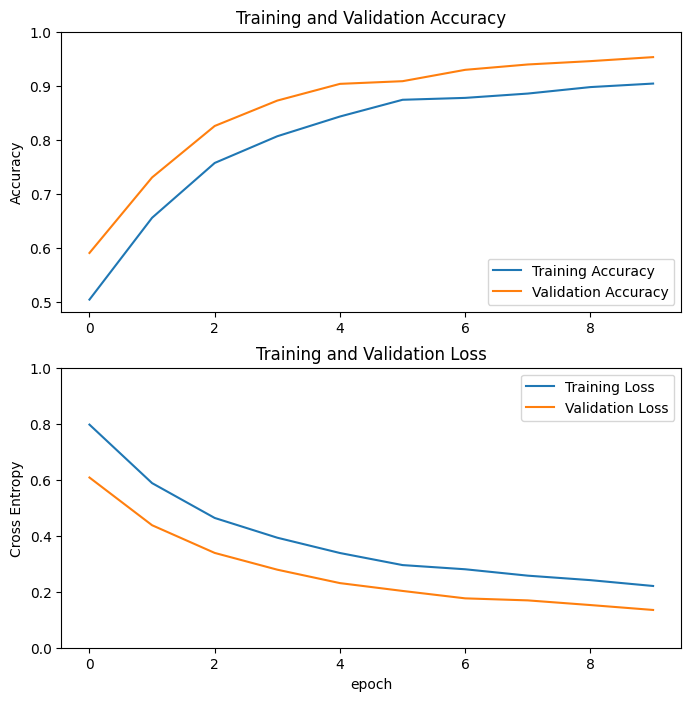

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,862,721


Non-trainable params: 396,544


_________________________________________________________________


In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 10:32 - loss: 0.2028 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.2057 - accuracy: 0.9375   

 3/63 [>.............................] - ETA: 4s - loss: 0.2116 - accuracy: 0.9167

 4/63 [>.............................] - ETA: 4s - loss: 0.2036 - accuracy: 0.9297

 5/63 [=>............................] - ETA: 4s - loss: 0.1969 - accuracy: 0.9250

 6/63 [=>............................] - ETA: 4s - loss: 0.1834 - accuracy: 0.9323

 7/63 [==>...........................] - ETA: 3s - loss: 0.1695 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 3s - loss: 0.1793 - accuracy: 0.9297

 9/63 [===>..........................] - ETA: 3s - loss: 0.1745 - accuracy: 0.9306

10/63 [===>..........................] - ETA: 3s - loss: 0.1894 - accuracy: 0.9250

11/63 [====>.........................] - ETA: 3s - loss: 0.1852 - accuracy: 0.9233

12/63 [====>.........................] - ETA: 3s - loss: 0.1795 - accuracy: 0.9245

13/63 [=====>........................] - ETA: 3s - loss: 0.1729 - accuracy: 0.9279

14/63 [=====>........................] - ETA: 3s - loss: 0.1684 - accuracy: 0.9286

15/63 [======>.......................] - ETA: 3s - loss: 0.1739 - accuracy: 0.9271

16/63 [======>.......................] - ETA: 3s - loss: 0.1744 - accuracy: 0.9258

17/63 [=======>......................] - ETA: 3s - loss: 0.1719 - accuracy: 0.9265

18/63 [=======>......................] - ETA: 3s - loss: 0.1654 - accuracy: 0.9306

19/63 [========>.....................] - ETA: 3s - loss: 0.1703 - accuracy: 0.9276

20/63 [========>.....................] - ETA: 2s - loss: 0.1675 - accuracy: 0.9281

21/63 [=========>....................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9271

22/63 [=========>....................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9261

23/63 [=========>....................] - ETA: 2s - loss: 0.1632 - accuracy: 0.9266

24/63 [==========>...................] - ETA: 2s - loss: 0.1586 - accuracy: 0.9297

25/63 [==========>...................] - ETA: 2s - loss: 0.1586 - accuracy: 0.9287

26/63 [===========>..................] - ETA: 2s - loss: 0.1606 - accuracy: 0.9255

27/63 [===========>..................] - ETA: 2s - loss: 0.1595 - accuracy: 0.9259

28/63 [============>.................] - ETA: 2s - loss: 0.1582 - accuracy: 0.9263

29/63 [============>.................] - ETA: 2s - loss: 0.1546 - accuracy: 0.9289

30/63 [=============>................] - ETA: 2s - loss: 0.1529 - accuracy: 0.9302

31/63 [=============>................] - ETA: 2s - loss: 0.1509 - accuracy: 0.9315

32/63 [==============>...............] - ETA: 2s - loss: 0.1555 - accuracy: 0.9297

33/63 [==============>...............] - ETA: 2s - loss: 0.1583 - accuracy: 0.9299

34/63 [===============>..............] - ETA: 1s - loss: 0.1614 - accuracy: 0.9274

35/63 [===============>..............] - ETA: 1s - loss: 0.1595 - accuracy: 0.9295

36/63 [================>.............] - ETA: 1s - loss: 0.1591 - accuracy: 0.9306

37/63 [================>.............] - ETA: 1s - loss: 0.1561 - accuracy: 0.9324

38/63 [=================>............] - ETA: 1s - loss: 0.1564 - accuracy: 0.9326

39/63 [=================>............] - ETA: 1s - loss: 0.1553 - accuracy: 0.9319

40/63 [==================>...........] - ETA: 1s - loss: 0.1536 - accuracy: 0.9336

41/63 [==================>...........] - ETA: 1s - loss: 0.1563 - accuracy: 0.9329

42/63 [===================>..........] - ETA: 1s - loss: 0.1549 - accuracy: 0.9330

43/63 [===================>..........] - ETA: 1s - loss: 0.1540 - accuracy: 0.9339

44/63 [===================>..........] - ETA: 1s - loss: 0.1549 - accuracy: 0.9339

45/63 [====================>.........] - ETA: 1s - loss: 0.1554 - accuracy: 0.9333

46/63 [====================>.........] - ETA: 1s - loss: 0.1538 - accuracy: 0.9348

47/63 [=====================>........] - ETA: 1s - loss: 0.1543 - accuracy: 0.9335

48/63 [=====================>........] - ETA: 1s - loss: 0.1538 - accuracy: 0.9336

49/63 [======================>.......] - ETA: 0s - loss: 0.1514 - accuracy: 0.9349

50/63 [======================>.......] - ETA: 0s - loss: 0.1495 - accuracy: 0.9362

51/63 [=======================>......] - ETA: 0s - loss: 0.1476 - accuracy: 0.9375

52/63 [=======================>......] - ETA: 0s - loss: 0.1464 - accuracy: 0.9375

53/63 [========================>.....] - ETA: 0s - loss: 0.1459 - accuracy: 0.9375

54/63 [========================>.....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9375

55/63 [=========================>....] - ETA: 0s - loss: 0.1439 - accuracy: 0.9381

56/63 [=========================>....] - ETA: 0s - loss: 0.1450 - accuracy: 0.9386

57/63 [==========================>...] - ETA: 0s - loss: 0.1459 - accuracy: 0.9386

58/63 [==========================>...] - ETA: 0s - loss: 0.1447 - accuracy: 0.9391

59/63 [===========================>..] - ETA: 0s - loss: 0.1454 - accuracy: 0.9380

60/63 [===========================>..] - ETA: 0s - loss: 0.1443 - accuracy: 0.9385

61/63 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9385

62/63 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9395

63/63 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9395

63/63 [==============================] - 16s 88ms/step - loss: 0.1425 - accuracy: 0.9395 - val_loss: 0.0548 - val_accuracy: 0.9802


Epoch 11/20


 1/63 [..............................] - ETA: 6s - loss: 0.0297 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0376 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 3s - loss: 0.0669 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.1077 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.1226 - accuracy: 0.9563

 6/63 [=>............................] - ETA: 4s - loss: 0.1295 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 3s - loss: 0.1451 - accuracy: 0.9464

 8/63 [==>...........................] - ETA: 3s - loss: 0.1296 - accuracy: 0.9531

 9/63 [===>..........................] - ETA: 3s - loss: 0.1280 - accuracy: 0.9444

10/63 [===>..........................] - ETA: 3s - loss: 0.1206 - accuracy: 0.9500

11/63 [====>.........................] - ETA: 3s - loss: 0.1120 - accuracy: 0.9545

12/63 [====>.........................] - ETA: 3s - loss: 0.1114 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 3s - loss: 0.1094 - accuracy: 0.9543

14/63 [=====>........................] - ETA: 3s - loss: 0.1034 - accuracy: 0.9576

15/63 [======>.......................] - ETA: 3s - loss: 0.1043 - accuracy: 0.9583

16/63 [======>.......................] - ETA: 3s - loss: 0.1003 - accuracy: 0.9609

17/63 [=======>......................] - ETA: 3s - loss: 0.1157 - accuracy: 0.9577

18/63 [=======>......................] - ETA: 3s - loss: 0.1188 - accuracy: 0.9566

19/63 [========>.....................] - ETA: 3s - loss: 0.1214 - accuracy: 0.9556

20/63 [========>.....................] - ETA: 2s - loss: 0.1256 - accuracy: 0.9547

21/63 [=========>....................] - ETA: 2s - loss: 0.1304 - accuracy: 0.9524

22/63 [=========>....................] - ETA: 2s - loss: 0.1317 - accuracy: 0.9531

23/63 [=========>....................] - ETA: 2s - loss: 0.1289 - accuracy: 0.9552

24/63 [==========>...................] - ETA: 2s - loss: 0.1321 - accuracy: 0.9531

25/63 [==========>...................] - ETA: 2s - loss: 0.1281 - accuracy: 0.9550

26/63 [===========>..................] - ETA: 2s - loss: 0.1246 - accuracy: 0.9567

27/63 [===========>..................] - ETA: 2s - loss: 0.1273 - accuracy: 0.9537

28/63 [============>.................] - ETA: 2s - loss: 0.1247 - accuracy: 0.9554

29/63 [============>.................] - ETA: 2s - loss: 0.1233 - accuracy: 0.9547

30/63 [=============>................] - ETA: 2s - loss: 0.1209 - accuracy: 0.9552

31/63 [=============>................] - ETA: 2s - loss: 0.1184 - accuracy: 0.9567

32/63 [==============>...............] - ETA: 2s - loss: 0.1180 - accuracy: 0.9570

33/63 [==============>...............] - ETA: 2s - loss: 0.1208 - accuracy: 0.9545

34/63 [===============>..............] - ETA: 2s - loss: 0.1219 - accuracy: 0.9540

35/63 [===============>..............] - ETA: 1s - loss: 0.1221 - accuracy: 0.9545

36/63 [================>.............] - ETA: 1s - loss: 0.1205 - accuracy: 0.9549

37/63 [================>.............] - ETA: 1s - loss: 0.1203 - accuracy: 0.9552

38/63 [=================>............] - ETA: 1s - loss: 0.1200 - accuracy: 0.9548

39/63 [=================>............] - ETA: 1s - loss: 0.1214 - accuracy: 0.9551

40/63 [==================>...........] - ETA: 1s - loss: 0.1260 - accuracy: 0.9539

41/63 [==================>...........] - ETA: 1s - loss: 0.1255 - accuracy: 0.9535

42/63 [===================>..........] - ETA: 1s - loss: 0.1349 - accuracy: 0.9501

43/63 [===================>..........] - ETA: 1s - loss: 0.1327 - accuracy: 0.9513

44/63 [===================>..........] - ETA: 1s - loss: 0.1311 - accuracy: 0.9524

45/63 [====================>.........] - ETA: 1s - loss: 0.1325 - accuracy: 0.9507

46/63 [====================>.........] - ETA: 1s - loss: 0.1352 - accuracy: 0.9497

47/63 [=====================>........] - ETA: 1s - loss: 0.1344 - accuracy: 0.9501

48/63 [=====================>........] - ETA: 1s - loss: 0.1329 - accuracy: 0.9505

49/63 [======================>.......] - ETA: 0s - loss: 0.1306 - accuracy: 0.9515

50/63 [======================>.......] - ETA: 0s - loss: 0.1292 - accuracy: 0.9519

51/63 [=======================>......] - ETA: 0s - loss: 0.1286 - accuracy: 0.9522

52/63 [=======================>......] - ETA: 0s - loss: 0.1276 - accuracy: 0.9525

53/63 [========================>.....] - ETA: 0s - loss: 0.1293 - accuracy: 0.9522

54/63 [========================>.....] - ETA: 0s - loss: 0.1288 - accuracy: 0.9525

55/63 [=========================>....] - ETA: 0s - loss: 0.1303 - accuracy: 0.9517

56/63 [=========================>....] - ETA: 0s - loss: 0.1298 - accuracy: 0.9509

57/63 [==========================>...] - ETA: 0s - loss: 0.1281 - accuracy: 0.9518

58/63 [==========================>...] - ETA: 0s - loss: 0.1261 - accuracy: 0.9526

59/63 [===========================>..] - ETA: 0s - loss: 0.1257 - accuracy: 0.9529

60/63 [===========================>..] - ETA: 0s - loss: 0.1247 - accuracy: 0.9531

61/63 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9524

62/63 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9531

63/63 [==============================] - 5s 76ms/step - loss: 0.1236 - accuracy: 0.9520 - val_loss: 0.0475 - val_accuracy: 0.9889


Epoch 12/20


 1/63 [..............................] - ETA: 6s - loss: 0.1298 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.1126 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 4s - loss: 0.1008 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 4s - loss: 0.0817 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.1034 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.1027 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 3s - loss: 0.1002 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.1032 - accuracy: 0.9531

 9/63 [===>..........................] - ETA: 3s - loss: 0.1165 - accuracy: 0.9479

10/63 [===>..........................] - ETA: 3s - loss: 0.1160 - accuracy: 0.9500

11/63 [====>.........................] - ETA: 3s - loss: 0.1132 - accuracy: 0.9517

12/63 [====>.........................] - ETA: 3s - loss: 0.1051 - accuracy: 0.9557

13/63 [=====>........................] - ETA: 3s - loss: 0.1145 - accuracy: 0.9495

14/63 [=====>........................] - ETA: 3s - loss: 0.1160 - accuracy: 0.9509

15/63 [======>.......................] - ETA: 3s - loss: 0.1190 - accuracy: 0.9500

16/63 [======>.......................] - ETA: 3s - loss: 0.1209 - accuracy: 0.9492

17/63 [=======>......................] - ETA: 3s - loss: 0.1158 - accuracy: 0.9522

18/63 [=======>......................] - ETA: 3s - loss: 0.1160 - accuracy: 0.9497

19/63 [========>.....................] - ETA: 2s - loss: 0.1178 - accuracy: 0.9490

20/63 [========>.....................] - ETA: 2s - loss: 0.1154 - accuracy: 0.9484

21/63 [=========>....................] - ETA: 2s - loss: 0.1124 - accuracy: 0.9509

22/63 [=========>....................] - ETA: 2s - loss: 0.1131 - accuracy: 0.9503

23/63 [=========>....................] - ETA: 2s - loss: 0.1131 - accuracy: 0.9511

24/63 [==========>...................] - ETA: 2s - loss: 0.1098 - accuracy: 0.9531

25/63 [==========>...................] - ETA: 2s - loss: 0.1104 - accuracy: 0.9525

26/63 [===========>..................] - ETA: 2s - loss: 0.1105 - accuracy: 0.9519

27/63 [===========>..................] - ETA: 2s - loss: 0.1165 - accuracy: 0.9502

28/63 [============>.................] - ETA: 2s - loss: 0.1151 - accuracy: 0.9509

29/63 [============>.................] - ETA: 2s - loss: 0.1126 - accuracy: 0.9515

30/63 [=============>................] - ETA: 2s - loss: 0.1112 - accuracy: 0.9521

31/63 [=============>................] - ETA: 2s - loss: 0.1082 - accuracy: 0.9536

32/63 [==============>...............] - ETA: 2s - loss: 0.1123 - accuracy: 0.9512

33/63 [==============>...............] - ETA: 2s - loss: 0.1128 - accuracy: 0.9517

34/63 [===============>..............] - ETA: 1s - loss: 0.1120 - accuracy: 0.9522

35/63 [===============>..............] - ETA: 1s - loss: 0.1113 - accuracy: 0.9518

36/63 [================>.............] - ETA: 1s - loss: 0.1137 - accuracy: 0.9497

37/63 [================>.............] - ETA: 1s - loss: 0.1196 - accuracy: 0.9476

38/63 [=================>............] - ETA: 1s - loss: 0.1211 - accuracy: 0.9474

39/63 [=================>............] - ETA: 1s - loss: 0.1196 - accuracy: 0.9479

40/63 [==================>...........] - ETA: 1s - loss: 0.1183 - accuracy: 0.9477

41/63 [==================>...........] - ETA: 1s - loss: 0.1162 - accuracy: 0.9489

42/63 [===================>..........] - ETA: 1s - loss: 0.1157 - accuracy: 0.9494

43/63 [===================>..........] - ETA: 1s - loss: 0.1180 - accuracy: 0.9484

44/63 [===================>..........] - ETA: 1s - loss: 0.1172 - accuracy: 0.9489

45/63 [====================>.........] - ETA: 1s - loss: 0.1155 - accuracy: 0.9500

46/63 [====================>.........] - ETA: 1s - loss: 0.1153 - accuracy: 0.9504

47/63 [=====================>........] - ETA: 1s - loss: 0.1156 - accuracy: 0.9508

48/63 [=====================>........] - ETA: 1s - loss: 0.1144 - accuracy: 0.9518

49/63 [======================>.......] - ETA: 0s - loss: 0.1142 - accuracy: 0.9515

50/63 [======================>.......] - ETA: 0s - loss: 0.1126 - accuracy: 0.9519

51/63 [=======================>......] - ETA: 0s - loss: 0.1114 - accuracy: 0.9528

52/63 [=======================>......] - ETA: 0s - loss: 0.1118 - accuracy: 0.9525

53/63 [========================>.....] - ETA: 0s - loss: 0.1113 - accuracy: 0.9528

54/63 [========================>.....] - ETA: 0s - loss: 0.1097 - accuracy: 0.9537

55/63 [=========================>....] - ETA: 0s - loss: 0.1082 - accuracy: 0.9545

56/63 [=========================>....] - ETA: 0s - loss: 0.1067 - accuracy: 0.9554

57/63 [==========================>...] - ETA: 0s - loss: 0.1050 - accuracy: 0.9561

58/63 [==========================>...] - ETA: 0s - loss: 0.1047 - accuracy: 0.9564

59/63 [===========================>..] - ETA: 0s - loss: 0.1084 - accuracy: 0.9550

60/63 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9547

61/63 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9549

62/63 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9546

63/63 [==============================] - 5s 75ms/step - loss: 0.1099 - accuracy: 0.9545 - val_loss: 0.0499 - val_accuracy: 0.9876


Epoch 13/20


 1/63 [..............................] - ETA: 6s - loss: 0.0241 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0261 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 3s - loss: 0.0550 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0485 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 3s - loss: 0.0547 - accuracy: 0.9750

 6/63 [=>............................] - ETA: 3s - loss: 0.0737 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 3s - loss: 0.0686 - accuracy: 0.9732

 8/63 [==>...........................] - ETA: 3s - loss: 0.0677 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 3s - loss: 0.0650 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 3s - loss: 0.0635 - accuracy: 0.9719

11/63 [====>.........................] - ETA: 3s - loss: 0.0615 - accuracy: 0.9744

12/63 [====>.........................] - ETA: 3s - loss: 0.0667 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 3s - loss: 0.0628 - accuracy: 0.9712

14/63 [=====>........................] - ETA: 3s - loss: 0.0598 - accuracy: 0.9732

15/63 [======>.......................] - ETA: 3s - loss: 0.0671 - accuracy: 0.9708

16/63 [======>.......................] - ETA: 3s - loss: 0.0693 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 3s - loss: 0.0681 - accuracy: 0.9706

18/63 [=======>......................] - ETA: 2s - loss: 0.0729 - accuracy: 0.9705

19/63 [========>.....................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9688

20/63 [========>.....................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 2s - loss: 0.0718 - accuracy: 0.9702

22/63 [=========>....................] - ETA: 2s - loss: 0.0788 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 2s - loss: 0.0791 - accuracy: 0.9701

24/63 [==========>...................] - ETA: 2s - loss: 0.0821 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 2s - loss: 0.0848 - accuracy: 0.9675

26/63 [===========>..................] - ETA: 2s - loss: 0.0826 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 2s - loss: 0.0818 - accuracy: 0.9688

28/63 [============>.................] - ETA: 2s - loss: 0.0815 - accuracy: 0.9688

29/63 [============>.................] - ETA: 2s - loss: 0.0836 - accuracy: 0.9677

30/63 [=============>................] - ETA: 2s - loss: 0.0833 - accuracy: 0.9667

31/63 [=============>................] - ETA: 2s - loss: 0.0821 - accuracy: 0.9667

32/63 [==============>...............] - ETA: 2s - loss: 0.0816 - accuracy: 0.9658

33/63 [==============>...............] - ETA: 1s - loss: 0.0884 - accuracy: 0.9621

34/63 [===============>..............] - ETA: 1s - loss: 0.0879 - accuracy: 0.9623

35/63 [===============>..............] - ETA: 1s - loss: 0.0857 - accuracy: 0.9634

36/63 [================>.............] - ETA: 1s - loss: 0.0859 - accuracy: 0.9618

37/63 [================>.............] - ETA: 1s - loss: 0.0880 - accuracy: 0.9603

38/63 [=================>............] - ETA: 1s - loss: 0.0874 - accuracy: 0.9613

39/63 [=================>............] - ETA: 1s - loss: 0.0862 - accuracy: 0.9623

40/63 [==================>...........] - ETA: 1s - loss: 0.0853 - accuracy: 0.9625

41/63 [==================>...........] - ETA: 1s - loss: 0.0849 - accuracy: 0.9627

42/63 [===================>..........] - ETA: 1s - loss: 0.0872 - accuracy: 0.9621

43/63 [===================>..........] - ETA: 1s - loss: 0.0866 - accuracy: 0.9622

44/63 [===================>..........] - ETA: 1s - loss: 0.0878 - accuracy: 0.9616

45/63 [====================>.........] - ETA: 1s - loss: 0.0864 - accuracy: 0.9625

46/63 [====================>.........] - ETA: 1s - loss: 0.0857 - accuracy: 0.9633

47/63 [=====================>........] - ETA: 1s - loss: 0.0849 - accuracy: 0.9641

48/63 [=====================>........] - ETA: 1s - loss: 0.0839 - accuracy: 0.9648

49/63 [======================>.......] - ETA: 0s - loss: 0.0826 - accuracy: 0.9656

50/63 [======================>.......] - ETA: 0s - loss: 0.0850 - accuracy: 0.9638

51/63 [=======================>......] - ETA: 0s - loss: 0.0837 - accuracy: 0.9645

52/63 [=======================>......] - ETA: 0s - loss: 0.0822 - accuracy: 0.9651

53/63 [========================>.....] - ETA: 0s - loss: 0.0816 - accuracy: 0.9652

54/63 [========================>.....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9653

55/63 [=========================>....] - ETA: 0s - loss: 0.0809 - accuracy: 0.9659

56/63 [=========================>....] - ETA: 0s - loss: 0.0800 - accuracy: 0.9660

57/63 [==========================>...] - ETA: 0s - loss: 0.0801 - accuracy: 0.9655

58/63 [==========================>...] - ETA: 0s - loss: 0.0858 - accuracy: 0.9639

59/63 [===========================>..] - ETA: 0s - loss: 0.0877 - accuracy: 0.9635

60/63 [===========================>..] - ETA: 0s - loss: 0.0870 - accuracy: 0.9635

61/63 [============================>.] - ETA: 0s - loss: 0.0863 - accuracy: 0.9641

62/63 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9637

63/63 [==============================] - 5s 75ms/step - loss: 0.0882 - accuracy: 0.9630 - val_loss: 0.0538 - val_accuracy: 0.9790


Epoch 14/20


 1/63 [..............................] - ETA: 6s - loss: 0.1663 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.1128 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 4s - loss: 0.1421 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 4s - loss: 0.1241 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 4s - loss: 0.1366 - accuracy: 0.9438

 6/63 [=>............................] - ETA: 3s - loss: 0.1467 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 3s - loss: 0.1421 - accuracy: 0.9464

 8/63 [==>...........................] - ETA: 3s - loss: 0.1551 - accuracy: 0.9453

 9/63 [===>..........................] - ETA: 3s - loss: 0.1441 - accuracy: 0.9479

10/63 [===>..........................] - ETA: 3s - loss: 0.1384 - accuracy: 0.9500

11/63 [====>.........................] - ETA: 3s - loss: 0.1288 - accuracy: 0.9545

12/63 [====>.........................] - ETA: 3s - loss: 0.1217 - accuracy: 0.9557

13/63 [=====>........................] - ETA: 3s - loss: 0.1275 - accuracy: 0.9519

14/63 [=====>........................] - ETA: 3s - loss: 0.1336 - accuracy: 0.9531

15/63 [======>.......................] - ETA: 3s - loss: 0.1343 - accuracy: 0.9479

16/63 [======>.......................] - ETA: 3s - loss: 0.1274 - accuracy: 0.9512

17/63 [=======>......................] - ETA: 3s - loss: 0.1219 - accuracy: 0.9540

18/63 [=======>......................] - ETA: 3s - loss: 0.1172 - accuracy: 0.9566

19/63 [========>.....................] - ETA: 3s - loss: 0.1121 - accuracy: 0.9589

20/63 [========>.....................] - ETA: 3s - loss: 0.1088 - accuracy: 0.9594

21/63 [=========>....................] - ETA: 2s - loss: 0.1049 - accuracy: 0.9613

22/63 [=========>....................] - ETA: 2s - loss: 0.1042 - accuracy: 0.9616

23/63 [=========>....................] - ETA: 2s - loss: 0.1011 - accuracy: 0.9620

24/63 [==========>...................] - ETA: 2s - loss: 0.0978 - accuracy: 0.9635

25/63 [==========>...................] - ETA: 2s - loss: 0.0944 - accuracy: 0.9650

26/63 [===========>..................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9663

27/63 [===========>..................] - ETA: 2s - loss: 0.0901 - accuracy: 0.9664

28/63 [============>.................] - ETA: 2s - loss: 0.0888 - accuracy: 0.9676

29/63 [============>.................] - ETA: 2s - loss: 0.0865 - accuracy: 0.9688

30/63 [=============>................] - ETA: 2s - loss: 0.0841 - accuracy: 0.9698

31/63 [=============>................] - ETA: 2s - loss: 0.0862 - accuracy: 0.9688

32/63 [==============>...............] - ETA: 2s - loss: 0.0947 - accuracy: 0.9668

33/63 [==============>...............] - ETA: 2s - loss: 0.0937 - accuracy: 0.9659

34/63 [===============>..............] - ETA: 2s - loss: 0.0939 - accuracy: 0.9660

35/63 [===============>..............] - ETA: 1s - loss: 0.0950 - accuracy: 0.9643

36/63 [================>.............] - ETA: 1s - loss: 0.0939 - accuracy: 0.9644

37/63 [================>.............] - ETA: 1s - loss: 0.0965 - accuracy: 0.9637

38/63 [=================>............] - ETA: 1s - loss: 0.0970 - accuracy: 0.9638

39/63 [=================>............] - ETA: 1s - loss: 0.0964 - accuracy: 0.9631

40/63 [==================>...........] - ETA: 1s - loss: 0.0957 - accuracy: 0.9633

41/63 [==================>...........] - ETA: 1s - loss: 0.0972 - accuracy: 0.9619

42/63 [===================>..........] - ETA: 1s - loss: 0.0957 - accuracy: 0.9628

43/63 [===================>..........] - ETA: 1s - loss: 0.0940 - accuracy: 0.9637

44/63 [===================>..........] - ETA: 1s - loss: 0.0940 - accuracy: 0.9624

45/63 [====================>.........] - ETA: 1s - loss: 0.0955 - accuracy: 0.9618

46/63 [====================>.........] - ETA: 1s - loss: 0.0958 - accuracy: 0.9620

47/63 [=====================>........] - ETA: 1s - loss: 0.0962 - accuracy: 0.9621

48/63 [=====================>........] - ETA: 1s - loss: 0.0973 - accuracy: 0.9616

49/63 [======================>.......] - ETA: 0s - loss: 0.0981 - accuracy: 0.9605

50/63 [======================>.......] - ETA: 0s - loss: 0.0989 - accuracy: 0.9594

51/63 [=======================>......] - ETA: 0s - loss: 0.0990 - accuracy: 0.9589

52/63 [=======================>......] - ETA: 0s - loss: 0.0979 - accuracy: 0.9597

53/63 [========================>.....] - ETA: 0s - loss: 0.0963 - accuracy: 0.9605

54/63 [========================>.....] - ETA: 0s - loss: 0.0961 - accuracy: 0.9601

55/63 [=========================>....] - ETA: 0s - loss: 0.0958 - accuracy: 0.9602

56/63 [=========================>....] - ETA: 0s - loss: 0.0951 - accuracy: 0.9604

57/63 [==========================>...] - ETA: 0s - loss: 0.0947 - accuracy: 0.9605

58/63 [==========================>...] - ETA: 0s - loss: 0.0945 - accuracy: 0.9607

59/63 [===========================>..] - ETA: 0s - loss: 0.0947 - accuracy: 0.9608

60/63 [===========================>..] - ETA: 0s - loss: 0.0942 - accuracy: 0.9609

61/63 [============================>.] - ETA: 0s - loss: 0.0951 - accuracy: 0.9606

62/63 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9592

63/63 [==============================] - 5s 77ms/step - loss: 0.0966 - accuracy: 0.9595 - val_loss: 0.0457 - val_accuracy: 0.9827


Epoch 15/20


 1/63 [..............................] - ETA: 6s - loss: 0.0508 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0838 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 3s - loss: 0.1150 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 3s - loss: 0.0904 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.0795 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 3s - loss: 0.0796 - accuracy: 0.9635

 7/63 [==>...........................] - ETA: 3s - loss: 0.0888 - accuracy: 0.9554

 8/63 [==>...........................] - ETA: 3s - loss: 0.0814 - accuracy: 0.9609

 9/63 [===>..........................] - ETA: 3s - loss: 0.0746 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 3s - loss: 0.0757 - accuracy: 0.9625

11/63 [====>.........................] - ETA: 3s - loss: 0.0770 - accuracy: 0.9631

12/63 [====>.........................] - ETA: 3s - loss: 0.0718 - accuracy: 0.9661

13/63 [=====>........................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9663

14/63 [=====>........................] - ETA: 3s - loss: 0.0747 - accuracy: 0.9665

15/63 [======>.......................] - ETA: 3s - loss: 0.0729 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 3s - loss: 0.0763 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 3s - loss: 0.0825 - accuracy: 0.9651

18/63 [=======>......................] - ETA: 2s - loss: 0.0790 - accuracy: 0.9670

19/63 [========>.....................] - ETA: 2s - loss: 0.0830 - accuracy: 0.9671

20/63 [========>.....................] - ETA: 2s - loss: 0.0840 - accuracy: 0.9672

21/63 [=========>....................] - ETA: 2s - loss: 0.0809 - accuracy: 0.9688

22/63 [=========>....................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 2s - loss: 0.0774 - accuracy: 0.9701

24/63 [==========>...................] - ETA: 2s - loss: 0.0766 - accuracy: 0.9701

25/63 [==========>...................] - ETA: 2s - loss: 0.0740 - accuracy: 0.9712

26/63 [===========>..................] - ETA: 2s - loss: 0.0739 - accuracy: 0.9712

27/63 [===========>..................] - ETA: 2s - loss: 0.0748 - accuracy: 0.9711

28/63 [============>.................] - ETA: 2s - loss: 0.0735 - accuracy: 0.9721

29/63 [============>.................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9709

30/63 [=============>................] - ETA: 2s - loss: 0.0723 - accuracy: 0.9698

31/63 [=============>................] - ETA: 2s - loss: 0.0792 - accuracy: 0.9698

32/63 [==============>...............] - ETA: 2s - loss: 0.0783 - accuracy: 0.9707

33/63 [==============>...............] - ETA: 1s - loss: 0.0765 - accuracy: 0.9716

34/63 [===============>..............] - ETA: 1s - loss: 0.0750 - accuracy: 0.9724

35/63 [===============>..............] - ETA: 1s - loss: 0.0756 - accuracy: 0.9705

36/63 [================>.............] - ETA: 1s - loss: 0.0761 - accuracy: 0.9696

37/63 [================>.............] - ETA: 1s - loss: 0.0774 - accuracy: 0.9696

38/63 [=================>............] - ETA: 1s - loss: 0.0768 - accuracy: 0.9696

39/63 [=================>............] - ETA: 1s - loss: 0.0755 - accuracy: 0.9704

40/63 [==================>...........] - ETA: 1s - loss: 0.0740 - accuracy: 0.9711

41/63 [==================>...........] - ETA: 1s - loss: 0.0764 - accuracy: 0.9703

42/63 [===================>..........] - ETA: 1s - loss: 0.0752 - accuracy: 0.9710

43/63 [===================>..........] - ETA: 1s - loss: 0.0758 - accuracy: 0.9709

44/63 [===================>..........] - ETA: 1s - loss: 0.0766 - accuracy: 0.9702

45/63 [====================>.........] - ETA: 1s - loss: 0.0760 - accuracy: 0.9708

46/63 [====================>.........] - ETA: 1s - loss: 0.0763 - accuracy: 0.9701

47/63 [=====================>........] - ETA: 1s - loss: 0.0764 - accuracy: 0.9701

48/63 [=====================>........] - ETA: 0s - loss: 0.0759 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0747 - accuracy: 0.9713

50/63 [======================>.......] - ETA: 0s - loss: 0.0747 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9706

52/63 [=======================>......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9688

53/63 [========================>.....] - ETA: 0s - loss: 0.0780 - accuracy: 0.9688

54/63 [========================>.....] - ETA: 0s - loss: 0.0772 - accuracy: 0.9693

55/63 [=========================>....] - ETA: 0s - loss: 0.0777 - accuracy: 0.9693

56/63 [=========================>....] - ETA: 0s - loss: 0.0766 - accuracy: 0.9699

57/63 [==========================>...] - ETA: 0s - loss: 0.0765 - accuracy: 0.9704

58/63 [==========================>...] - ETA: 0s - loss: 0.0762 - accuracy: 0.9704

59/63 [===========================>..] - ETA: 0s - loss: 0.0760 - accuracy: 0.9703

60/63 [===========================>..] - ETA: 0s - loss: 0.0752 - accuracy: 0.9708

61/63 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9703

62/63 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9708

63/63 [==============================] - 5s 74ms/step - loss: 0.0760 - accuracy: 0.9710 - val_loss: 0.0415 - val_accuracy: 0.9864


Epoch 16/20


 1/63 [..............................] - ETA: 6s - loss: 0.0323 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0213 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0372 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 4s - loss: 0.0617 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.0766 - accuracy: 0.9750

 6/63 [=>............................] - ETA: 3s - loss: 0.0655 - accuracy: 0.9792

 7/63 [==>...........................] - ETA: 3s - loss: 0.0844 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 3s - loss: 0.0767 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 3s - loss: 0.0719 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 3s - loss: 0.1003 - accuracy: 0.9625

11/63 [====>.........................] - ETA: 3s - loss: 0.0941 - accuracy: 0.9659

12/63 [====>.........................] - ETA: 3s - loss: 0.0909 - accuracy: 0.9661

13/63 [=====>........................] - ETA: 3s - loss: 0.0913 - accuracy: 0.9663

14/63 [=====>........................] - ETA: 3s - loss: 0.0894 - accuracy: 0.9665

15/63 [======>.......................] - ETA: 3s - loss: 0.0946 - accuracy: 0.9646

16/63 [======>.......................] - ETA: 3s - loss: 0.0932 - accuracy: 0.9648

17/63 [=======>......................] - ETA: 3s - loss: 0.0901 - accuracy: 0.9651

18/63 [=======>......................] - ETA: 3s - loss: 0.0892 - accuracy: 0.9635

19/63 [========>.....................] - ETA: 3s - loss: 0.0857 - accuracy: 0.9655

20/63 [========>.....................] - ETA: 2s - loss: 0.0846 - accuracy: 0.9656

21/63 [=========>....................] - ETA: 2s - loss: 0.0811 - accuracy: 0.9673

22/63 [=========>....................] - ETA: 2s - loss: 0.0828 - accuracy: 0.9645

23/63 [=========>....................] - ETA: 2s - loss: 0.0812 - accuracy: 0.9647

24/63 [==========>...................] - ETA: 2s - loss: 0.0805 - accuracy: 0.9648

25/63 [==========>...................] - ETA: 2s - loss: 0.0792 - accuracy: 0.9650

26/63 [===========>..................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9639

27/63 [===========>..................] - ETA: 2s - loss: 0.0828 - accuracy: 0.9630

28/63 [============>.................] - ETA: 2s - loss: 0.0812 - accuracy: 0.9643

29/63 [============>.................] - ETA: 2s - loss: 0.0808 - accuracy: 0.9644

30/63 [=============>................] - ETA: 2s - loss: 0.0784 - accuracy: 0.9656

31/63 [=============>................] - ETA: 2s - loss: 0.0778 - accuracy: 0.9657

32/63 [==============>...............] - ETA: 2s - loss: 0.0758 - accuracy: 0.9668

33/63 [==============>...............] - ETA: 2s - loss: 0.0787 - accuracy: 0.9659

34/63 [===============>..............] - ETA: 1s - loss: 0.0780 - accuracy: 0.9651

35/63 [===============>..............] - ETA: 1s - loss: 0.0776 - accuracy: 0.9652

36/63 [================>.............] - ETA: 1s - loss: 0.0778 - accuracy: 0.9644

37/63 [================>.............] - ETA: 1s - loss: 0.0804 - accuracy: 0.9637

38/63 [=================>............] - ETA: 1s - loss: 0.0826 - accuracy: 0.9630

39/63 [=================>............] - ETA: 1s - loss: 0.0835 - accuracy: 0.9631

40/63 [==================>...........] - ETA: 1s - loss: 0.0847 - accuracy: 0.9625

41/63 [==================>...........] - ETA: 1s - loss: 0.0836 - accuracy: 0.9627

42/63 [===================>..........] - ETA: 1s - loss: 0.0838 - accuracy: 0.9628

43/63 [===================>..........] - ETA: 1s - loss: 0.0880 - accuracy: 0.9615

44/63 [===================>..........] - ETA: 1s - loss: 0.0890 - accuracy: 0.9616

45/63 [====================>.........] - ETA: 1s - loss: 0.0885 - accuracy: 0.9618

46/63 [====================>.........] - ETA: 1s - loss: 0.0910 - accuracy: 0.9613

47/63 [=====================>........] - ETA: 1s - loss: 0.0913 - accuracy: 0.9608

48/63 [=====================>........] - ETA: 1s - loss: 0.0898 - accuracy: 0.9616

49/63 [======================>.......] - ETA: 0s - loss: 0.0883 - accuracy: 0.9624

50/63 [======================>.......] - ETA: 0s - loss: 0.0882 - accuracy: 0.9625

51/63 [=======================>......] - ETA: 0s - loss: 0.0879 - accuracy: 0.9626

52/63 [=======================>......] - ETA: 0s - loss: 0.0874 - accuracy: 0.9633

53/63 [========================>.....] - ETA: 0s - loss: 0.0875 - accuracy: 0.9634

54/63 [========================>.....] - ETA: 0s - loss: 0.0868 - accuracy: 0.9635

55/63 [=========================>....] - ETA: 0s - loss: 0.0870 - accuracy: 0.9631

56/63 [=========================>....] - ETA: 0s - loss: 0.0858 - accuracy: 0.9637

57/63 [==========================>...] - ETA: 0s - loss: 0.0872 - accuracy: 0.9627

58/63 [==========================>...] - ETA: 0s - loss: 0.0861 - accuracy: 0.9634

59/63 [===========================>..] - ETA: 0s - loss: 0.0847 - accuracy: 0.9640

60/63 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9646

61/63 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9641

62/63 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9637

63/63 [==============================] - 5s 75ms/step - loss: 0.0851 - accuracy: 0.9640 - val_loss: 0.0564 - val_accuracy: 0.9765


Epoch 17/20


 1/63 [..............................] - ETA: 6s - loss: 0.0304 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0635 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 4s - loss: 0.0448 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 3s - loss: 0.0378 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 3s - loss: 0.0710 - accuracy: 0.9875

 6/63 [=>............................] - ETA: 3s - loss: 0.0755 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 3s - loss: 0.0982 - accuracy: 0.9732

 8/63 [==>...........................] - ETA: 3s - loss: 0.0928 - accuracy: 0.9766

 9/63 [===>..........................] - ETA: 3s - loss: 0.0876 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 3s - loss: 0.0811 - accuracy: 0.9812

11/63 [====>.........................] - ETA: 3s - loss: 0.0781 - accuracy: 0.9830

12/63 [====>.........................] - ETA: 3s - loss: 0.0772 - accuracy: 0.9818

13/63 [=====>........................] - ETA: 3s - loss: 0.0796 - accuracy: 0.9808

14/63 [=====>........................] - ETA: 3s - loss: 0.0758 - accuracy: 0.9821

15/63 [======>.......................] - ETA: 3s - loss: 0.0785 - accuracy: 0.9812

16/63 [======>.......................] - ETA: 3s - loss: 0.0759 - accuracy: 0.9824

17/63 [=======>......................] - ETA: 3s - loss: 0.0722 - accuracy: 0.9835

18/63 [=======>......................] - ETA: 2s - loss: 0.0706 - accuracy: 0.9826

19/63 [========>.....................] - ETA: 2s - loss: 0.0692 - accuracy: 0.9836

20/63 [========>.....................] - ETA: 2s - loss: 0.0697 - accuracy: 0.9828

21/63 [=========>....................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9821

22/63 [=========>....................] - ETA: 2s - loss: 0.0717 - accuracy: 0.9830

23/63 [=========>....................] - ETA: 2s - loss: 0.0715 - accuracy: 0.9823

24/63 [==========>...................] - ETA: 2s - loss: 0.0691 - accuracy: 0.9831

25/63 [==========>...................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9825

26/63 [===========>..................] - ETA: 2s - loss: 0.0686 - accuracy: 0.9820

27/63 [===========>..................] - ETA: 2s - loss: 0.0667 - accuracy: 0.9826

28/63 [============>.................] - ETA: 2s - loss: 0.0677 - accuracy: 0.9821

29/63 [============>.................] - ETA: 2s - loss: 0.0683 - accuracy: 0.9806

30/63 [=============>................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9802

31/63 [=============>................] - ETA: 2s - loss: 0.0659 - accuracy: 0.9808

32/63 [==============>...............] - ETA: 2s - loss: 0.0686 - accuracy: 0.9795

33/63 [==============>...............] - ETA: 1s - loss: 0.0681 - accuracy: 0.9792

34/63 [===============>..............] - ETA: 1s - loss: 0.0689 - accuracy: 0.9789

35/63 [===============>..............] - ETA: 1s - loss: 0.0681 - accuracy: 0.9786

36/63 [================>.............] - ETA: 1s - loss: 0.0676 - accuracy: 0.9783

37/63 [================>.............] - ETA: 1s - loss: 0.0671 - accuracy: 0.9780

38/63 [=================>............] - ETA: 1s - loss: 0.0664 - accuracy: 0.9778

39/63 [=================>............] - ETA: 1s - loss: 0.0674 - accuracy: 0.9768

40/63 [==================>...........] - ETA: 1s - loss: 0.0704 - accuracy: 0.9758

41/63 [==================>...........] - ETA: 1s - loss: 0.0716 - accuracy: 0.9756

42/63 [===================>..........] - ETA: 1s - loss: 0.0778 - accuracy: 0.9740

43/63 [===================>..........] - ETA: 1s - loss: 0.0768 - accuracy: 0.9746

44/63 [===================>..........] - ETA: 1s - loss: 0.0754 - accuracy: 0.9751

45/63 [====================>.........] - ETA: 1s - loss: 0.0750 - accuracy: 0.9750

46/63 [====================>.........] - ETA: 1s - loss: 0.0756 - accuracy: 0.9749

47/63 [=====================>........] - ETA: 1s - loss: 0.0773 - accuracy: 0.9747

48/63 [=====================>........] - ETA: 0s - loss: 0.0763 - accuracy: 0.9746

49/63 [======================>.......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9745

50/63 [======================>.......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9750

51/63 [=======================>......] - ETA: 0s - loss: 0.0760 - accuracy: 0.9743

52/63 [=======================>......] - ETA: 0s - loss: 0.0759 - accuracy: 0.9742

53/63 [========================>.....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9746

54/63 [========================>.....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9745

55/63 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9750

56/63 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9749

57/63 [==========================>...] - ETA: 0s - loss: 0.0738 - accuracy: 0.9737

58/63 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9741

59/63 [===========================>..] - ETA: 0s - loss: 0.0732 - accuracy: 0.9740

60/63 [===========================>..] - ETA: 0s - loss: 0.0739 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9744

62/63 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9743

63/63 [==============================] - 5s 73ms/step - loss: 0.0721 - accuracy: 0.9740 - val_loss: 0.0537 - val_accuracy: 0.9839


Epoch 18/20


 1/63 [..............................] - ETA: 6s - loss: 0.1510 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.1032 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.1179 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1772 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 3s - loss: 0.1491 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 3s - loss: 0.1467 - accuracy: 0.9479

 7/63 [==>...........................] - ETA: 3s - loss: 0.1433 - accuracy: 0.9509

 8/63 [==>...........................] - ETA: 3s - loss: 0.1330 - accuracy: 0.9531

 9/63 [===>..........................] - ETA: 3s - loss: 0.1257 - accuracy: 0.9583

10/63 [===>..........................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9563

11/63 [====>.........................] - ETA: 3s - loss: 0.1201 - accuracy: 0.9574

12/63 [====>.........................] - ETA: 3s - loss: 0.1185 - accuracy: 0.9583

13/63 [=====>........................] - ETA: 3s - loss: 0.1139 - accuracy: 0.9615

14/63 [=====>........................] - ETA: 3s - loss: 0.1089 - accuracy: 0.9621

15/63 [======>.......................] - ETA: 3s - loss: 0.1025 - accuracy: 0.9646

16/63 [======>.......................] - ETA: 3s - loss: 0.1092 - accuracy: 0.9590

17/63 [=======>......................] - ETA: 2s - loss: 0.1033 - accuracy: 0.9614

18/63 [=======>......................] - ETA: 2s - loss: 0.1045 - accuracy: 0.9601

19/63 [========>.....................] - ETA: 2s - loss: 0.1002 - accuracy: 0.9622

20/63 [========>.....................] - ETA: 2s - loss: 0.0958 - accuracy: 0.9641

21/63 [=========>....................] - ETA: 2s - loss: 0.0928 - accuracy: 0.9658

22/63 [=========>....................] - ETA: 2s - loss: 0.0896 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 2s - loss: 0.0863 - accuracy: 0.9688

24/63 [==========>...................] - ETA: 2s - loss: 0.0840 - accuracy: 0.9701

25/63 [==========>...................] - ETA: 2s - loss: 0.0837 - accuracy: 0.9688

26/63 [===========>..................] - ETA: 2s - loss: 0.0824 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 2s - loss: 0.0843 - accuracy: 0.9676

28/63 [============>.................] - ETA: 2s - loss: 0.0838 - accuracy: 0.9676

29/63 [============>.................] - ETA: 2s - loss: 0.0822 - accuracy: 0.9688

30/63 [=============>................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9698

31/63 [=============>................] - ETA: 2s - loss: 0.0789 - accuracy: 0.9708

32/63 [==============>...............] - ETA: 2s - loss: 0.0788 - accuracy: 0.9707

33/63 [==============>...............] - ETA: 1s - loss: 0.0776 - accuracy: 0.9706

34/63 [===============>..............] - ETA: 1s - loss: 0.0778 - accuracy: 0.9706

35/63 [===============>..............] - ETA: 1s - loss: 0.0768 - accuracy: 0.9705

36/63 [================>.............] - ETA: 1s - loss: 0.0754 - accuracy: 0.9714

37/63 [================>.............] - ETA: 1s - loss: 0.0749 - accuracy: 0.9704

38/63 [=================>............] - ETA: 1s - loss: 0.0742 - accuracy: 0.9704

39/63 [=================>............] - ETA: 1s - loss: 0.0736 - accuracy: 0.9704

40/63 [==================>...........] - ETA: 1s - loss: 0.0742 - accuracy: 0.9695

41/63 [==================>...........] - ETA: 1s - loss: 0.0734 - accuracy: 0.9695

42/63 [===================>..........] - ETA: 1s - loss: 0.0755 - accuracy: 0.9680

43/63 [===================>..........] - ETA: 1s - loss: 0.0743 - accuracy: 0.9680

44/63 [===================>..........] - ETA: 1s - loss: 0.0729 - accuracy: 0.9688

45/63 [====================>.........] - ETA: 1s - loss: 0.0720 - accuracy: 0.9694

46/63 [====================>.........] - ETA: 1s - loss: 0.0729 - accuracy: 0.9694

47/63 [=====================>........] - ETA: 1s - loss: 0.0714 - accuracy: 0.9701

48/63 [=====================>........] - ETA: 0s - loss: 0.0702 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0706 - accuracy: 0.9707

50/63 [======================>.......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0755 - accuracy: 0.9694

52/63 [=======================>......] - ETA: 0s - loss: 0.0746 - accuracy: 0.9700

53/63 [========================>.....] - ETA: 0s - loss: 0.0754 - accuracy: 0.9693

54/63 [========================>.....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9693

55/63 [=========================>....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9693

56/63 [=========================>....] - ETA: 0s - loss: 0.0738 - accuracy: 0.9693

57/63 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9698

58/63 [==========================>...] - ETA: 0s - loss: 0.0722 - accuracy: 0.9704

59/63 [===========================>..] - ETA: 0s - loss: 0.0721 - accuracy: 0.9703

60/63 [===========================>..] - ETA: 0s - loss: 0.0724 - accuracy: 0.9698

61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9693

62/63 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9693

63/63 [==============================] - 5s 73ms/step - loss: 0.0735 - accuracy: 0.9695 - val_loss: 0.0468 - val_accuracy: 0.9827


Epoch 19/20


 1/63 [..............................] - ETA: 6s - loss: 0.0243 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0493 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0504 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0543 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.0804 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 3s - loss: 0.0706 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.0641 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 3s - loss: 0.0630 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 3s - loss: 0.0673 - accuracy: 0.9625

11/63 [====>.........................] - ETA: 3s - loss: 0.0630 - accuracy: 0.9659

12/63 [====>.........................] - ETA: 3s - loss: 0.0584 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 3s - loss: 0.0579 - accuracy: 0.9688

14/63 [=====>........................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 3s - loss: 0.0557 - accuracy: 0.9708

16/63 [======>.......................] - ETA: 3s - loss: 0.0558 - accuracy: 0.9707

17/63 [=======>......................] - ETA: 3s - loss: 0.0532 - accuracy: 0.9724

18/63 [=======>......................] - ETA: 2s - loss: 0.0521 - accuracy: 0.9740

19/63 [========>.....................] - ETA: 2s - loss: 0.0495 - accuracy: 0.9753

20/63 [========>.....................] - ETA: 2s - loss: 0.0510 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0491 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0511 - accuracy: 0.9759

23/63 [=========>....................] - ETA: 2s - loss: 0.0523 - accuracy: 0.9755

24/63 [==========>...................] - ETA: 2s - loss: 0.0568 - accuracy: 0.9740

25/63 [==========>...................] - ETA: 2s - loss: 0.0561 - accuracy: 0.9737

26/63 [===========>..................] - ETA: 2s - loss: 0.0568 - accuracy: 0.9736

27/63 [===========>..................] - ETA: 2s - loss: 0.0594 - accuracy: 0.9734

28/63 [============>.................] - ETA: 2s - loss: 0.0584 - accuracy: 0.9732

29/63 [============>.................] - ETA: 2s - loss: 0.0614 - accuracy: 0.9720

30/63 [=============>................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9729

31/63 [=============>................] - ETA: 2s - loss: 0.0600 - accuracy: 0.9728

32/63 [==============>...............] - ETA: 2s - loss: 0.0625 - accuracy: 0.9717

33/63 [==============>...............] - ETA: 1s - loss: 0.0615 - accuracy: 0.9716

34/63 [===============>..............] - ETA: 1s - loss: 0.0599 - accuracy: 0.9724

35/63 [===============>..............] - ETA: 1s - loss: 0.0618 - accuracy: 0.9723

36/63 [================>.............] - ETA: 1s - loss: 0.0605 - accuracy: 0.9731

37/63 [================>.............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9738

38/63 [=================>............] - ETA: 1s - loss: 0.0594 - accuracy: 0.9729

39/63 [=================>............] - ETA: 1s - loss: 0.0583 - accuracy: 0.9736

40/63 [==================>...........] - ETA: 1s - loss: 0.0578 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 1s - loss: 0.0567 - accuracy: 0.9748

42/63 [===================>..........] - ETA: 1s - loss: 0.0566 - accuracy: 0.9747

43/63 [===================>..........] - ETA: 1s - loss: 0.0598 - accuracy: 0.9738

44/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9730

45/63 [====================>.........] - ETA: 1s - loss: 0.0632 - accuracy: 0.9722

46/63 [====================>.........] - ETA: 1s - loss: 0.0622 - accuracy: 0.9728

47/63 [=====================>........] - ETA: 1s - loss: 0.0618 - accuracy: 0.9727

48/63 [=====================>........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9727

49/63 [======================>.......] - ETA: 0s - loss: 0.0630 - accuracy: 0.9719

50/63 [======================>.......] - ETA: 0s - loss: 0.0625 - accuracy: 0.9719

51/63 [=======================>......] - ETA: 0s - loss: 0.0626 - accuracy: 0.9712

52/63 [=======================>......] - ETA: 0s - loss: 0.0657 - accuracy: 0.9700

53/63 [========================>.....] - ETA: 0s - loss: 0.0648 - accuracy: 0.9705

54/63 [========================>.....] - ETA: 0s - loss: 0.0639 - accuracy: 0.9711

55/63 [=========================>....] - ETA: 0s - loss: 0.0630 - accuracy: 0.9716

56/63 [=========================>....] - ETA: 0s - loss: 0.0623 - accuracy: 0.9721

57/63 [==========================>...] - ETA: 0s - loss: 0.0628 - accuracy: 0.9720

58/63 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9720

59/63 [===========================>..] - ETA: 0s - loss: 0.0622 - accuracy: 0.9725

60/63 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9724

61/63 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9728

62/63 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9733

63/63 [==============================] - 5s 74ms/step - loss: 0.0604 - accuracy: 0.9730 - val_loss: 0.0540 - val_accuracy: 0.9827


Epoch 20/20


 1/63 [..............................] - ETA: 6s - loss: 0.0061 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0687 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0508 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0514 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.0444 - accuracy: 0.9812

 6/63 [=>............................] - ETA: 3s - loss: 0.0538 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 3s - loss: 0.0496 - accuracy: 0.9777

 8/63 [==>...........................] - ETA: 3s - loss: 0.0487 - accuracy: 0.9766

 9/63 [===>..........................] - ETA: 3s - loss: 0.0492 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 3s - loss: 0.0587 - accuracy: 0.9719

11/63 [====>.........................] - ETA: 3s - loss: 0.0557 - accuracy: 0.9744

12/63 [====>.........................] - ETA: 3s - loss: 0.0548 - accuracy: 0.9740

13/63 [=====>........................] - ETA: 3s - loss: 0.0522 - accuracy: 0.9736

14/63 [=====>........................] - ETA: 3s - loss: 0.0501 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 3s - loss: 0.0536 - accuracy: 0.9750

16/63 [======>.......................] - ETA: 3s - loss: 0.0514 - accuracy: 0.9766

17/63 [=======>......................] - ETA: 3s - loss: 0.0516 - accuracy: 0.9761

18/63 [=======>......................] - ETA: 2s - loss: 0.0552 - accuracy: 0.9757

19/63 [========>.....................] - ETA: 2s - loss: 0.0549 - accuracy: 0.9753

20/63 [========>.....................] - ETA: 2s - loss: 0.0524 - accuracy: 0.9766

21/63 [=========>....................] - ETA: 2s - loss: 0.0509 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0506 - accuracy: 0.9759

23/63 [=========>....................] - ETA: 2s - loss: 0.0503 - accuracy: 0.9755

24/63 [==========>...................] - ETA: 2s - loss: 0.0494 - accuracy: 0.9753

25/63 [==========>...................] - ETA: 2s - loss: 0.0506 - accuracy: 0.9750

26/63 [===========>..................] - ETA: 2s - loss: 0.0508 - accuracy: 0.9748

27/63 [===========>..................] - ETA: 2s - loss: 0.0497 - accuracy: 0.9757

28/63 [============>.................] - ETA: 2s - loss: 0.0523 - accuracy: 0.9754

29/63 [============>.................] - ETA: 2s - loss: 0.0529 - accuracy: 0.9763

30/63 [=============>................] - ETA: 2s - loss: 0.0542 - accuracy: 0.9760

31/63 [=============>................] - ETA: 2s - loss: 0.0551 - accuracy: 0.9758

32/63 [==============>...............] - ETA: 2s - loss: 0.0550 - accuracy: 0.9756

33/63 [==============>...............] - ETA: 1s - loss: 0.0572 - accuracy: 0.9744

34/63 [===============>..............] - ETA: 1s - loss: 0.0557 - accuracy: 0.9752

35/63 [===============>..............] - ETA: 1s - loss: 0.0600 - accuracy: 0.9732

36/63 [================>.............] - ETA: 1s - loss: 0.0596 - accuracy: 0.9731

37/63 [================>.............] - ETA: 1s - loss: 0.0599 - accuracy: 0.9721

38/63 [=================>............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9729

39/63 [=================>............] - ETA: 1s - loss: 0.0586 - accuracy: 0.9720

40/63 [==================>...........] - ETA: 1s - loss: 0.0641 - accuracy: 0.9703

41/63 [==================>...........] - ETA: 1s - loss: 0.0636 - accuracy: 0.9703

42/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9710

43/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9702

44/63 [===================>..........] - ETA: 1s - loss: 0.0631 - accuracy: 0.9702

45/63 [====================>.........] - ETA: 1s - loss: 0.0653 - accuracy: 0.9694

46/63 [====================>.........] - ETA: 1s - loss: 0.0641 - accuracy: 0.9701

47/63 [=====================>........] - ETA: 1s - loss: 0.0636 - accuracy: 0.9701

48/63 [=====================>........] - ETA: 0s - loss: 0.0628 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0620 - accuracy: 0.9713

50/63 [======================>.......] - ETA: 0s - loss: 0.0644 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0641 - accuracy: 0.9718

52/63 [=======================>......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9724

53/63 [========================>.....] - ETA: 0s - loss: 0.0629 - accuracy: 0.9723

54/63 [========================>.....] - ETA: 0s - loss: 0.0623 - accuracy: 0.9728

55/63 [=========================>....] - ETA: 0s - loss: 0.0615 - accuracy: 0.9733

56/63 [=========================>....] - ETA: 0s - loss: 0.0611 - accuracy: 0.9732

57/63 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9737

58/63 [==========================>...] - ETA: 0s - loss: 0.0592 - accuracy: 0.9741

59/63 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9740

60/63 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9739

62/63 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9738

63/63 [==============================] - 5s 74ms/step - loss: 0.0618 - accuracy: 0.9740 - val_loss: 0.0380 - val_accuracy: 0.9864


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

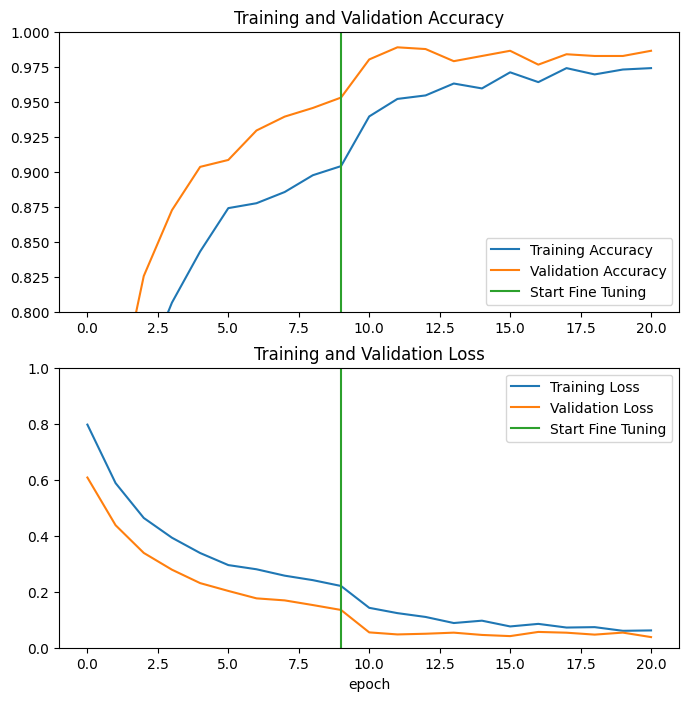

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0914 - accuracy: 0.9375

4/6 [===================>..........] - ETA: 0s - loss: 0.0655 - accuracy: 0.9531

6/6 [==============================] - 0s 19ms/step - loss: 0.0443 - accuracy: 0.9688


Test accuracy : 0.96875


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1]
Labels:
 [1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1]


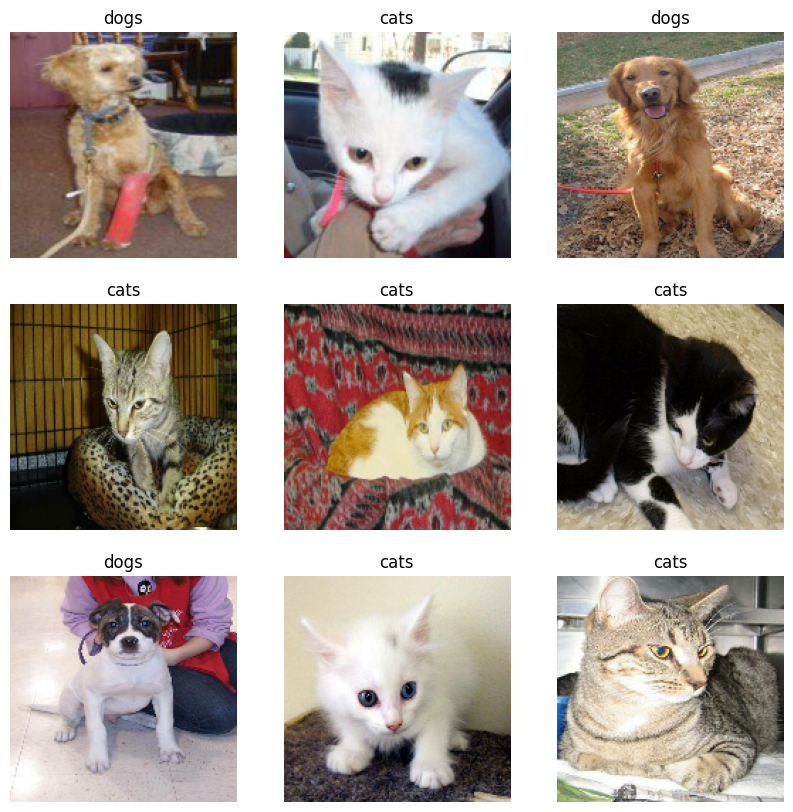

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
